## Package Installations and drive setup

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_36375/1151448009.py:15: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
%%R
library(tidyverse)
library(dyno)

Error in library(tidyverse) : there is no package called ‘tidyverse’
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
Error in library(tidyverse) : there is no package called ‘tidyverse’


RInterpreterError: Failed to parse and evaluate line 'library(tidyverse)\nlibrary(dyno)\n'.
R error message: 'Error in library(tidyverse) : there is no package called ‘tidyverse’'
R stdout:
Error in library(tidyverse) : there is no package called ‘tidyverse’
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages

In [3]:
import scanpy
# import dca
# import magic-impute
# import louvain
import pygam
import phate
import phenograph

In [4]:
import palantir

In [5]:
import pyVIA

/home/satwik/dynooenv/lib/python3.12/site-packages/phate/__init__.py


## Preprocessing

In [6]:
%matplotlib inline
# %run main.py

In [7]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [8]:
# Load data
data_path = 'placenta-trophoblast-differentiation-invasive_mca.h5ad'
adata = sc.read(data_path)

In [9]:
adata.to_df().shape

(1740, 2588)

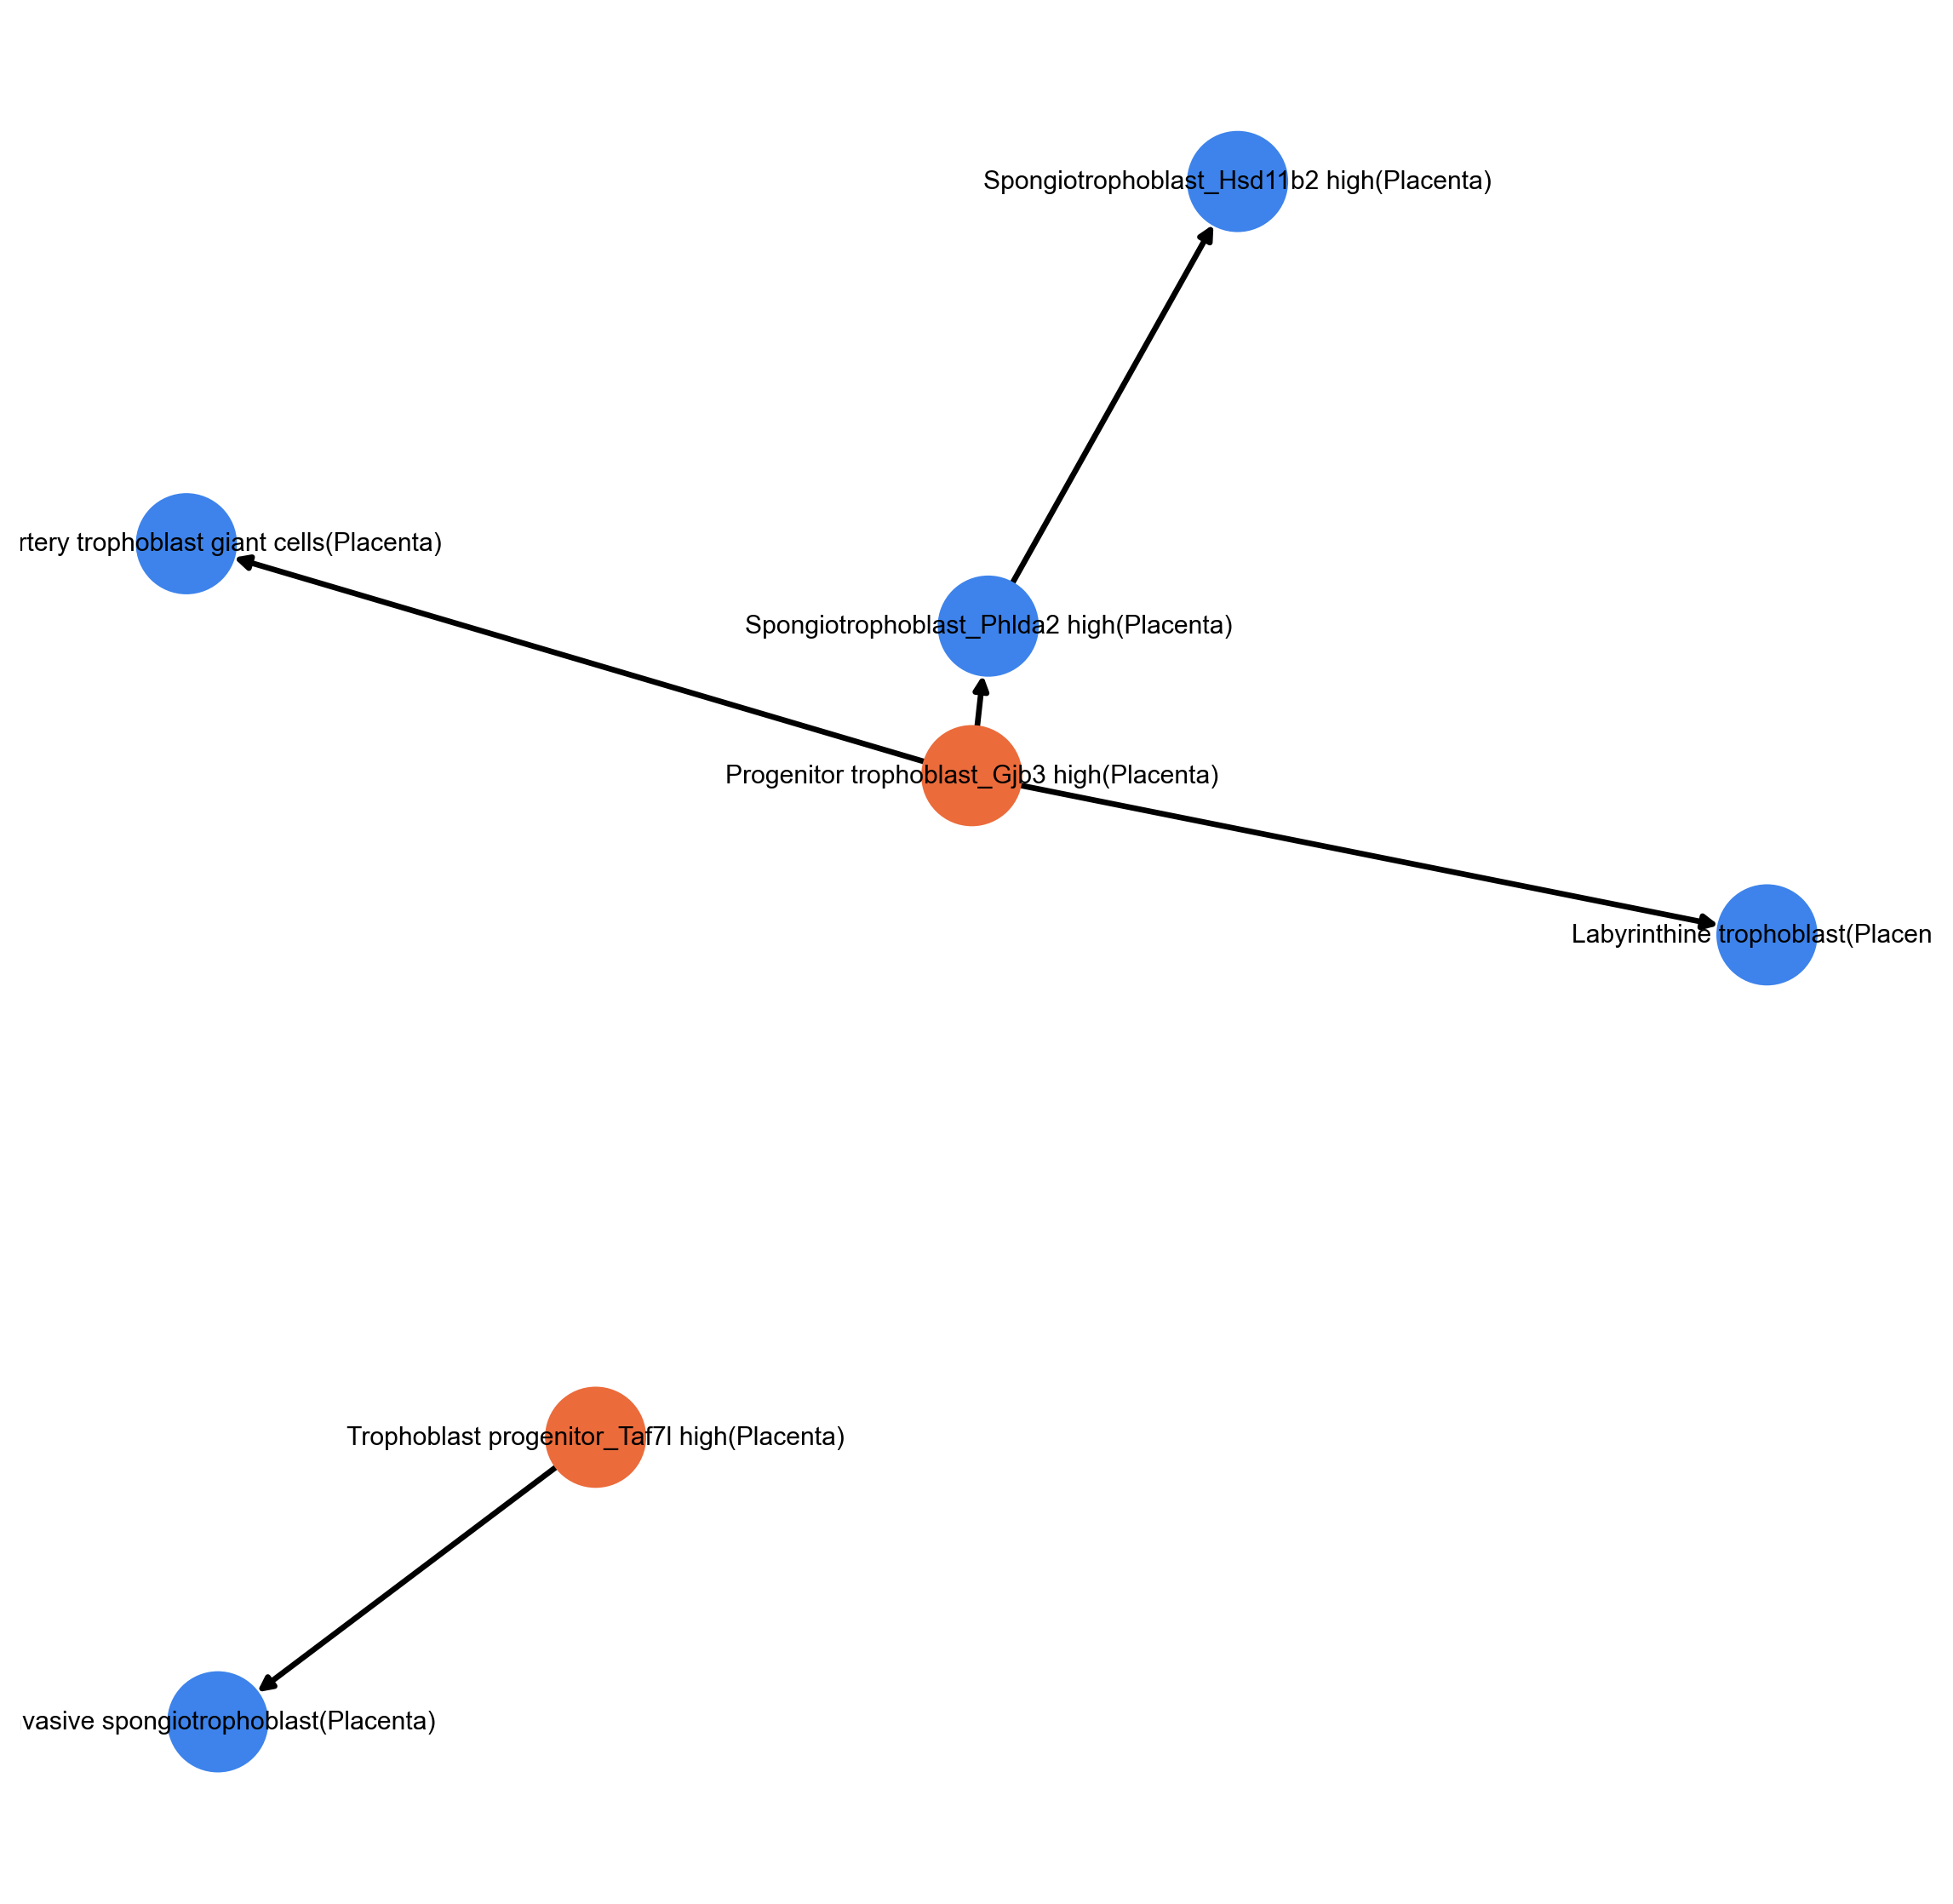

In [10]:
from utils.plot import plot_gt_milestone_network

plot_gt_milestone_network(adata, start_node_color='#EB6B3B', node_color='#3D83EB', node_size=1200)

In [11]:
# Extract the index of the start cell(s) from adata.obs_names
start_ids = [np.where(adata.obs_names == start_id)[0][0] for start_id in np.atleast_1d(adata.uns['start_id'])]
start_ids

[584, 112]

In [12]:
from utils.util import preprocess_recipe

# Preprocessing using Seurat default parameters
min_expr_level = 3
min_cells = None
use_hvg = False
n_top_genes = 1000
preprocessed_data = preprocess_recipe(
    adata,
    min_expr_level=min_expr_level,
    min_cells=min_cells,
    use_hvg=use_hvg,
    n_top_genes=n_top_genes,
    scale=True
)

Preprocessing....
	->Removed cells with expression level<3
	->Normalized data
	->Applying z-score normalization
Pre-processing complete. Updated data shape: (1740, 2588)
Runtime for preprocess_recipe(): 0.09280848503112793


In [13]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, _, n_comps = run_pca(preprocessed_data, use_hvg=False, n_components=10)
preprocessed_data.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 0.0897831916809082
Components computed: 10


In [14]:
gt_clusters = pd.Series(index=preprocessed_data.obs_names)

In [15]:
for obs_name in preprocessed_data.obs_names:
    res = (preprocessed_data.uns['milestone_percentages']['cell_id'] == obs_name)
    milestones = preprocessed_data.uns['milestone_percentages'].loc[res, 'milestone_id']
    percentages = preprocessed_data.uns['milestone_percentages'].loc[res, 'percentage']
    cluster_id = milestones.loc[percentages.idxmax()]
    gt_clusters.loc[obs_name] = cluster_id

In [16]:
preprocessed_data.obs['gt_clusters'] = gt_clusters

# VIA

In [17]:
import pyVIA.core as via

In [18]:
resolution = 1.0

In [19]:
# v0 = via.VIA(preprocessed_data.obsm['X_pca'], preprocessed_data.obs['gt_clusters'], jac_std_global=0.15, dist_std_local=1, knn=30,
#              too_big_factor=0.3, root_user=start_ids, dataset='', random_seed=0, resolution_parameter=resolution, preserve_disconnected=True)  # *.4 root=1,
# v0.run_VIA()

In [20]:
v0 = via.VIA(
    preprocessed_data.obsm['X_pca'],
    preprocessed_data.obs['gt_clusters'],
    # jac_std_global=0.15,
    # dist_std_local=1,
    knn=30,
    too_big_factor=0.3,
    root_user=start_ids,
    dataset='',
    random_seed=0,
    resolution_parameter=resolution,
)
v0.run_VIA()

2025-04-15 01:02:08.308672	Running VIA over input data of 1740 (samples) x 10 (features)
2025-04-15 01:02:08.308899	Knngraph has 30 neighbors
2025-04-15 01:02:09.004338	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 49.6 % of edges. 
2025-04-15 01:02:09.016906	Number of connected components used for clustergraph  is 1
2025-04-15 01:02:09.114108	Commencing community detection
2025-04-15 01:02:09.216328	Finished community detection. Found 33 clusters.
2025-04-15 01:02:09.217144	Merging 16 very small clusters (<10)
2025-04-15 01:02:09.218203	Finished detecting communities. Found 17 communities
2025-04-15 01:02:09.218329	Making cluster graph. Global cluster graph pruning level: 0.15
2025-04-15 01:02:09.221870	Graph has 1 connected components before pruning
2025-04-15 01:02:09.223002	Graph has 3 connected components after pruning
2025-04-15 01:02:09.225088	Graph has 1 connected components after reconnecting
2025-04-15 01:02:09.225448	0.0% links trimmed fr

/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-04-15 01:02:16.696751	Identifying terminal clusters corresponding to unique lineages...
2025-04-15 01:02:16.696788	Closeness:[1, 2, 3, 5, 7, 12, 13, 16]
2025-04-15 01:02:16.696803	Betweenness:[0, 1, 2, 3, 4, 7, 11, 12, 13, 14, 16]
2025-04-15 01:02:16.696811	Out Degree:[0, 2, 3, 4, 8, 9, 13, 16]
2025-04-15 01:02:16.696970	We removed cluster 1 from the shortlist of terminal states
2025-04-15 01:02:16.697092	Terminal clusters corresponding to unique lineages in this component are [0, 2, 4, 13, 16] 
2025-04-15 01:02:16.697106	Calculating lineage probability at memory 5


/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-15 01:02:20.316312	Cluster or terminal cell fate 0 is reached 10.0 times
2025-04-15 01:02:20.357037	Cluster or terminal cell fate 2 is reached 939.0 times
2025-04-15 01:02:20.384218	Cluster or terminal cell fate 4 is reached 37.0 times
2025-04-15 01:02:20.411278	Cluster or terminal cell fate 13 is reached 10.0 times
2025-04-15 01:02:20.436955	Cluster or terminal cell fate 16 is reached 2.0 times
2025-04-15 01:02:20.441809	There are (5) terminal clusters corresponding to unique lineages {0: 'Spongiotrophoblast_Phlda2 high(Placenta)', 2: 'Invasive spongiotrophoblast(Placenta)', 4: 'Progenitor trophoblast_Gjb3 high(Placenta)', 13: 'Spongiotrophoblast_Hsd11b2 high(Placenta)', 16: 'Labyrinthine trophoblast(Placenta)'}
2025-04-15 01:02:20.441866	Begin projection of pseudotime and lineage likelihood
2025-04-15 01:02:20.663021	Cluster graph layout based on forward biasing
2025-04-15 01:02:20.665466	Starting make edgebundle viagraph...
2025-04-15 01:02:20.665495	Make via clustergraph ed

In [21]:
import networkx as nx

via_graph = nx.Graph()

for pair in v0.edgelist:
    n1, n2 = pair
    via_graph.add_edge(n1, n2)

In [22]:
from metrics.ipsen import IpsenMikhailov
from models.ti.graph import compute_gt_milestone_network


gt_graph = net1 = compute_gt_milestone_network(preprocessed_data, mode="undirected")
im = IpsenMikhailov()
dist = im(via_graph, gt_graph)

print(dist)

Runtime for compute_gt_milestone_network(): 0.0008873939514160156
0.5130381520172393


In [23]:
from metrics.ordering import compute_ranking_correlation


via_pt = v0.single_cell_pt_markov
gt_pseudotime = preprocessed_data.uns["timecourse"].reindex(preprocessed_data.obs_names)

res = compute_ranking_correlation(gt_pseudotime, via_pt)
print(res)

{'kendall': SignificanceResult(statistic=-0.1202238775656249, pvalue=1.0408599227888704e-09), 'weighted_kendall': SignificanceResult(statistic=0.670659156868908, pvalue=nan), 'spearman': SignificanceResult(statistic=-0.13072483564571466, pvalue=4.436171281842513e-08)}


In [24]:
print(via_pt)

[0.07893381821409272, 0.0793077115617848, 0.053676585930260874, 0.0793077115617848, 0.07893381821409272, 0.07893381821409272, 0.07893381821409272, 0.07893381821409272, 0.26807767435493496, 0.07893381821409272, 0.26807767435493496, 0.07893381821409272, 1.0, 1.0, 0.26807767435493496, 0.07893381821409272, 0.07051474078614876, 0.07893381821409272, 0.18456157638222748, 0.0, 0.0793077115617848, 0.07893381821409272, 1.0, 1.0, 0.07893381821409272, 0.18456157638222748, 0.6032193850242009, 0.26807767435493496, 1.0, 0.07893381821409272, 0.0793077115617848, 0.07893381821409272, 0.07893381821409272, 0.26807767435493496, 0.07051474078614876, 0.07893381821409272, 0.080055498257169, 0.07893381821409272, 0.5867760502185454, 0.0, 0.053676585930260874, 0.49435302416210086, 0.26807767435493496, 0.07893381821409272, 0.07893381821409272, 0.07893381821409272, 0.053676585930260874, 0.06246955670589691, 0.053370332171445996, 0.26807767435493496, 0.07893381821409272, 0.07893381821409272, 0.0, 1.0, 0.07893381821

# Via metrics

In [3]:
%%R
dataset <- readRDS("placenta-trophoblast-differentiation-invasive_mca.rds")

In [26]:
%%R
library(dyndimred)
pca_dimred <- dimred_pca(
  dataset$expression
)

In [27]:
%%R
v_dataset <- readRDS("placenta-trophoblast-differentiation-invasive_mca.rds")

In [28]:
cell_ids = preprocessed_data.obs_names.to_list()
v_pseudotime = pd.Series(v0.single_cell_pt_markov, index=cell_ids)
v_milestone_ids = [i for i in range(len(set(v0.labels)))]
v_hard_clusters = v0.labels

In [29]:
fromlist = []
tolist = []
for t in v0.edgelist:
    if(t[0] > t[1]):
        continue
    fromlist.append(str(t[0]))
    tolist.append(str(t[1]))
v_edges_df = pd.DataFrame({'from': fromlist, 'to': tolist, 'length': 1, 'directed': False})
v_edges_df

,from,to,length,directed
0,0,13,1,False
1,0,15,1,False
2,1,2,1,False
3,1,3,1,False
4,1,7,1,False
5,1,12,1,False
6,2,3,1,False
7,2,7,1,False
8,3,5,1,False
9,4,11,1,False


In [30]:
for i in range(len(v_milestone_ids)):
    v_milestone_ids[i] = str(v_milestone_ids[i])

In [31]:
labels = v0.labels.copy()
for i in range(len(labels)):
    labels[i] = str(labels[i])
v_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': labels, 'percentage': [1 for i in range(len(labels))]})

In [32]:
%%R -i cell_ids -i v_pseudotime -i v_milestone_ids -i v_milestone_percentages -i v_edges_df
v_traj <- add_trajectory(
  v_dataset,
  cell_ids = cell_ids,
  pseudotime = v_pseudotime,
  milestone_ids = as.vector(v_milestone_ids),
  milestone_percentages = v_milestone_percentages,
  milestone_network = v_edges_df
)

In [33]:
%%R
name_mapping <- c(
  "Invasive spongiotrophoblast(Placenta)" = "Invasive",
  "Spiral artery trophoblast giant cells(Placenta)" = "Spiral artery",
  "Spongiotrophoblast_Hsd11b2 high(Placenta)" = "Hsd11b2 high",
  "Spongiotrophoblast_Phlda2 high(Placenta)" = "Phlda2 high",
  "Labyrinthine trophoblast(Placenta)" = "Labyrinthine",
  "Progenitor trophoblast_Gjb3 high(Placenta)" = "Gjb3 high",
  "Trophoblast progenitor_Taf7l high(Placenta)" = "Taf7l high"
)

In [41]:
%%R
library(RColorBrewer)
palette <- brewer.pal(n = length(unique(dataset$grouping)), name = "Set3")

In [42]:
%%R
library(dplyr)
groups <- recode(dataset$grouping, !!!name_mapping)
groups

   [1] "Invasive"      "Invasive"      "Invasive"      "Invasive"     
   [5] "Invasive"      "Invasive"      "Invasive"      "Invasive"     
   [9] "Spiral artery" "Invasive"      "Spiral artery" "Invasive"     
  [13] "Hsd11b2 high"  "Phlda2 high"   "Spiral artery" "Invasive"     
  [17] "Invasive"      "Invasive"      "Spiral artery" "Invasive"     
  [21] "Invasive"      "Invasive"      "Labyrinthine"  "Labyrinthine" 
  [25] "Invasive"      "Spiral artery" "Invasive"      "Spiral artery"
  [29] "Labyrinthine"  "Invasive"      "Invasive"      "Invasive"     
  [33] "Invasive"      "Spiral artery" "Invasive"      "Invasive"     
  [37] "Invasive"      "Invasive"      "Gjb3 high"     "Invasive"     
  [41] "Invasive"      "Gjb3 high"     "Spiral artery" "Invasive"     
  [45] "Invasive"      "Invasive"      "Invasive"      "Invasive"     
  [49] "Invasive"      "Spiral artery" "Invasive"      "Invasive"     
  [53] "Invasive"      "Hsd11b2 high"  "Invasive"      "Invasive"     
  [57]

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


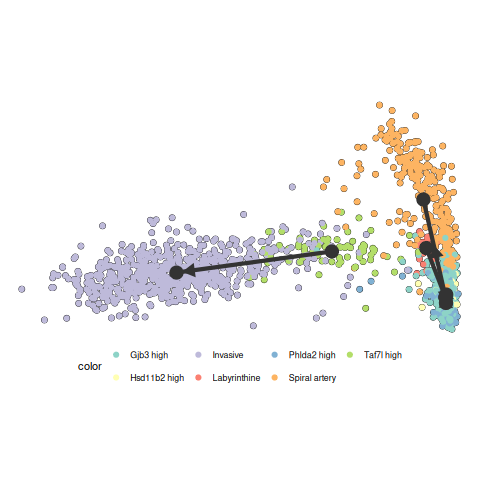

In [43]:
%%R
plot_dimred(dataset, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


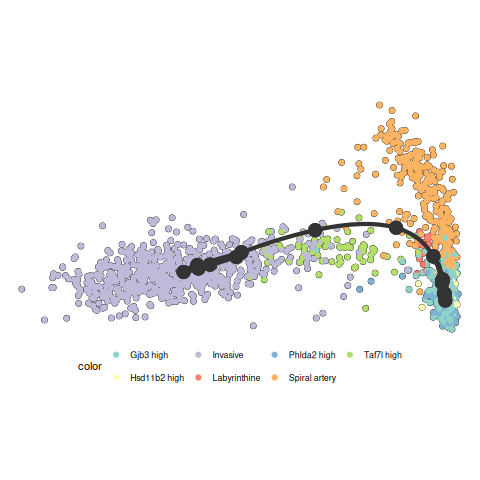

In [44]:
%%R
plot_dimred(v_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [37]:
%%R
library(dyneval)

In [38]:
%%R
via_metrics <- calculate_metrics(
  dataset = v_dataset,
  model = v_traj,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = v_dataset$expression
)

In addition: Warning message:
`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.
ℹ The deprecated feature was likely used in the dyneval package.
  Please report the issue to the authors.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


In [39]:
%%R
cat("HIM =", via_metrics$him, "\n")
cat("F1_branches =", via_metrics$F1_branches, "\n")
cat("correlation =", via_metrics$correlation, "\n")
cat("featureimp_wcor =", via_metrics$featureimp_wcor, "\n")
v_selected_metrics <- c(
  him = as.numeric(via_metrics$him),
  F1_branches = via_metrics$F1_branches,
  correlation = via_metrics$correlation,
  featureimp_wcor = via_metrics$featureimp_wcor
)
v_overall_score <- exp(mean(log(v_selected_metrics)))
cat("overall_score =", v_overall_score, "\n")

HIM = 0.4290196 
F1_branches = 0.279151 
correlation = 0.7300637 
featureimp_wcor = 0.847778 
overall_score = 0.5217828 


# margaret

In [45]:
import warnings
from train_metric import train_metric_learner

with warnings.catch_warnings():
    # Filter out user warnings from PyTorch about saving scheduler state
    warnings.simplefilter("ignore")
    train_metric_learner(preprocessed_data, n_episodes=10, n_metric_epochs=10, obsm_data_key='X_pca', code_size=10,
        backend='leiden', device='cpu', save_path='metric',
        # cluster_kwargs={'random_state': 0, 'n_clusters': 30}, nn_kwargs={'random_state': 0, 'n_neighbors': 10},
        cluster_kwargs={'random_state': 0, 'resolution': 1.0}, nn_kwargs={'random_state': 0, 'n_neighbors': 30},
        trainer_kwargs={
            'optimizer': 'SGD',
            'lr': 0.01,
            'batch_size': 256,
            'train_loader_kwargs': {'num_workers': 2, 'pin_memory': True, 'drop_last': True}
        },
        loss_kwargs={
            'margin': 1.0,
            'p': 2
        }
    )

Generating initial clusters
Runtime for determine_cell_clusters(): 3.589158773422241
Training for episode: 1


100%|██████████| 1740/1740 [00:00<00:00, 11497.96it/s]


Re-generating clusters for episode: 1
Runtime for determine_cell_clusters(): 0.6636881828308105
Time Elapsed for epoch: 6.265739917755127s
Training for episode: 2


100%|██████████| 1740/1740 [00:00<00:00, 12622.02it/s]


Re-generating clusters for episode: 2
Runtime for determine_cell_clusters(): 0.7172384262084961
Time Elapsed for epoch: 6.013636350631714s
Training for episode: 3


100%|██████████| 1740/1740 [00:00<00:00, 10357.04it/s]


Re-generating clusters for episode: 3
Runtime for determine_cell_clusters(): 0.7486672401428223
Time Elapsed for epoch: 7.857693672180176s
Training for episode: 4


100%|██████████| 1740/1740 [00:00<00:00, 11529.64it/s]


Re-generating clusters for episode: 4
Runtime for determine_cell_clusters(): 0.4991440773010254
Time Elapsed for epoch: 6.365972518920898s
Training for episode: 5


100%|██████████| 1740/1740 [00:00<00:00, 12007.62it/s]


Re-generating clusters for episode: 5
Runtime for determine_cell_clusters(): 0.6914355754852295
Time Elapsed for epoch: 6.390395641326904s
Training for episode: 6


100%|██████████| 1740/1740 [00:00<00:00, 7589.59it/s]


Re-generating clusters for episode: 6
Runtime for determine_cell_clusters(): 0.625598669052124
Time Elapsed for epoch: 6.049746990203857s
Training for episode: 7


100%|██████████| 1740/1740 [00:00<00:00, 12139.16it/s]


Re-generating clusters for episode: 7
Runtime for determine_cell_clusters(): 0.6942911148071289
Time Elapsed for epoch: 6.267622947692871s
Training for episode: 8


100%|██████████| 1740/1740 [00:00<00:00, 11029.02it/s]


Re-generating clusters for episode: 8
Runtime for determine_cell_clusters(): 0.606360912322998
Time Elapsed for epoch: 6.124370574951172s
Training for episode: 9


100%|██████████| 1740/1740 [00:00<00:00, 9713.16it/s]


Re-generating clusters for episode: 9
Runtime for determine_cell_clusters(): 0.548591136932373
Time Elapsed for epoch: 6.379413604736328s
Training for episode: 10


100%|██████████| 1740/1740 [00:00<00:00, 9533.74it/s]


Re-generating clusters for episode: 10
Runtime for determine_cell_clusters(): 0.6628882884979248
Time Elapsed for epoch: 6.5174291133880615s
Runtime for train_metric_learner(): 69.58722567558289


In [46]:
from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters
import matplotlib.pyplot as plt

In [47]:
X_embedded = generate_plot_embeddings(preprocessed_data.obsm['metric_embedding'], method='umap', random_state=random_seed)
preprocessed_data.obsm['X_met_embedding'] = X_embedded

/home/satwik/dynooenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Runtime for generate_plot_embeddings(): 7.669262886047363


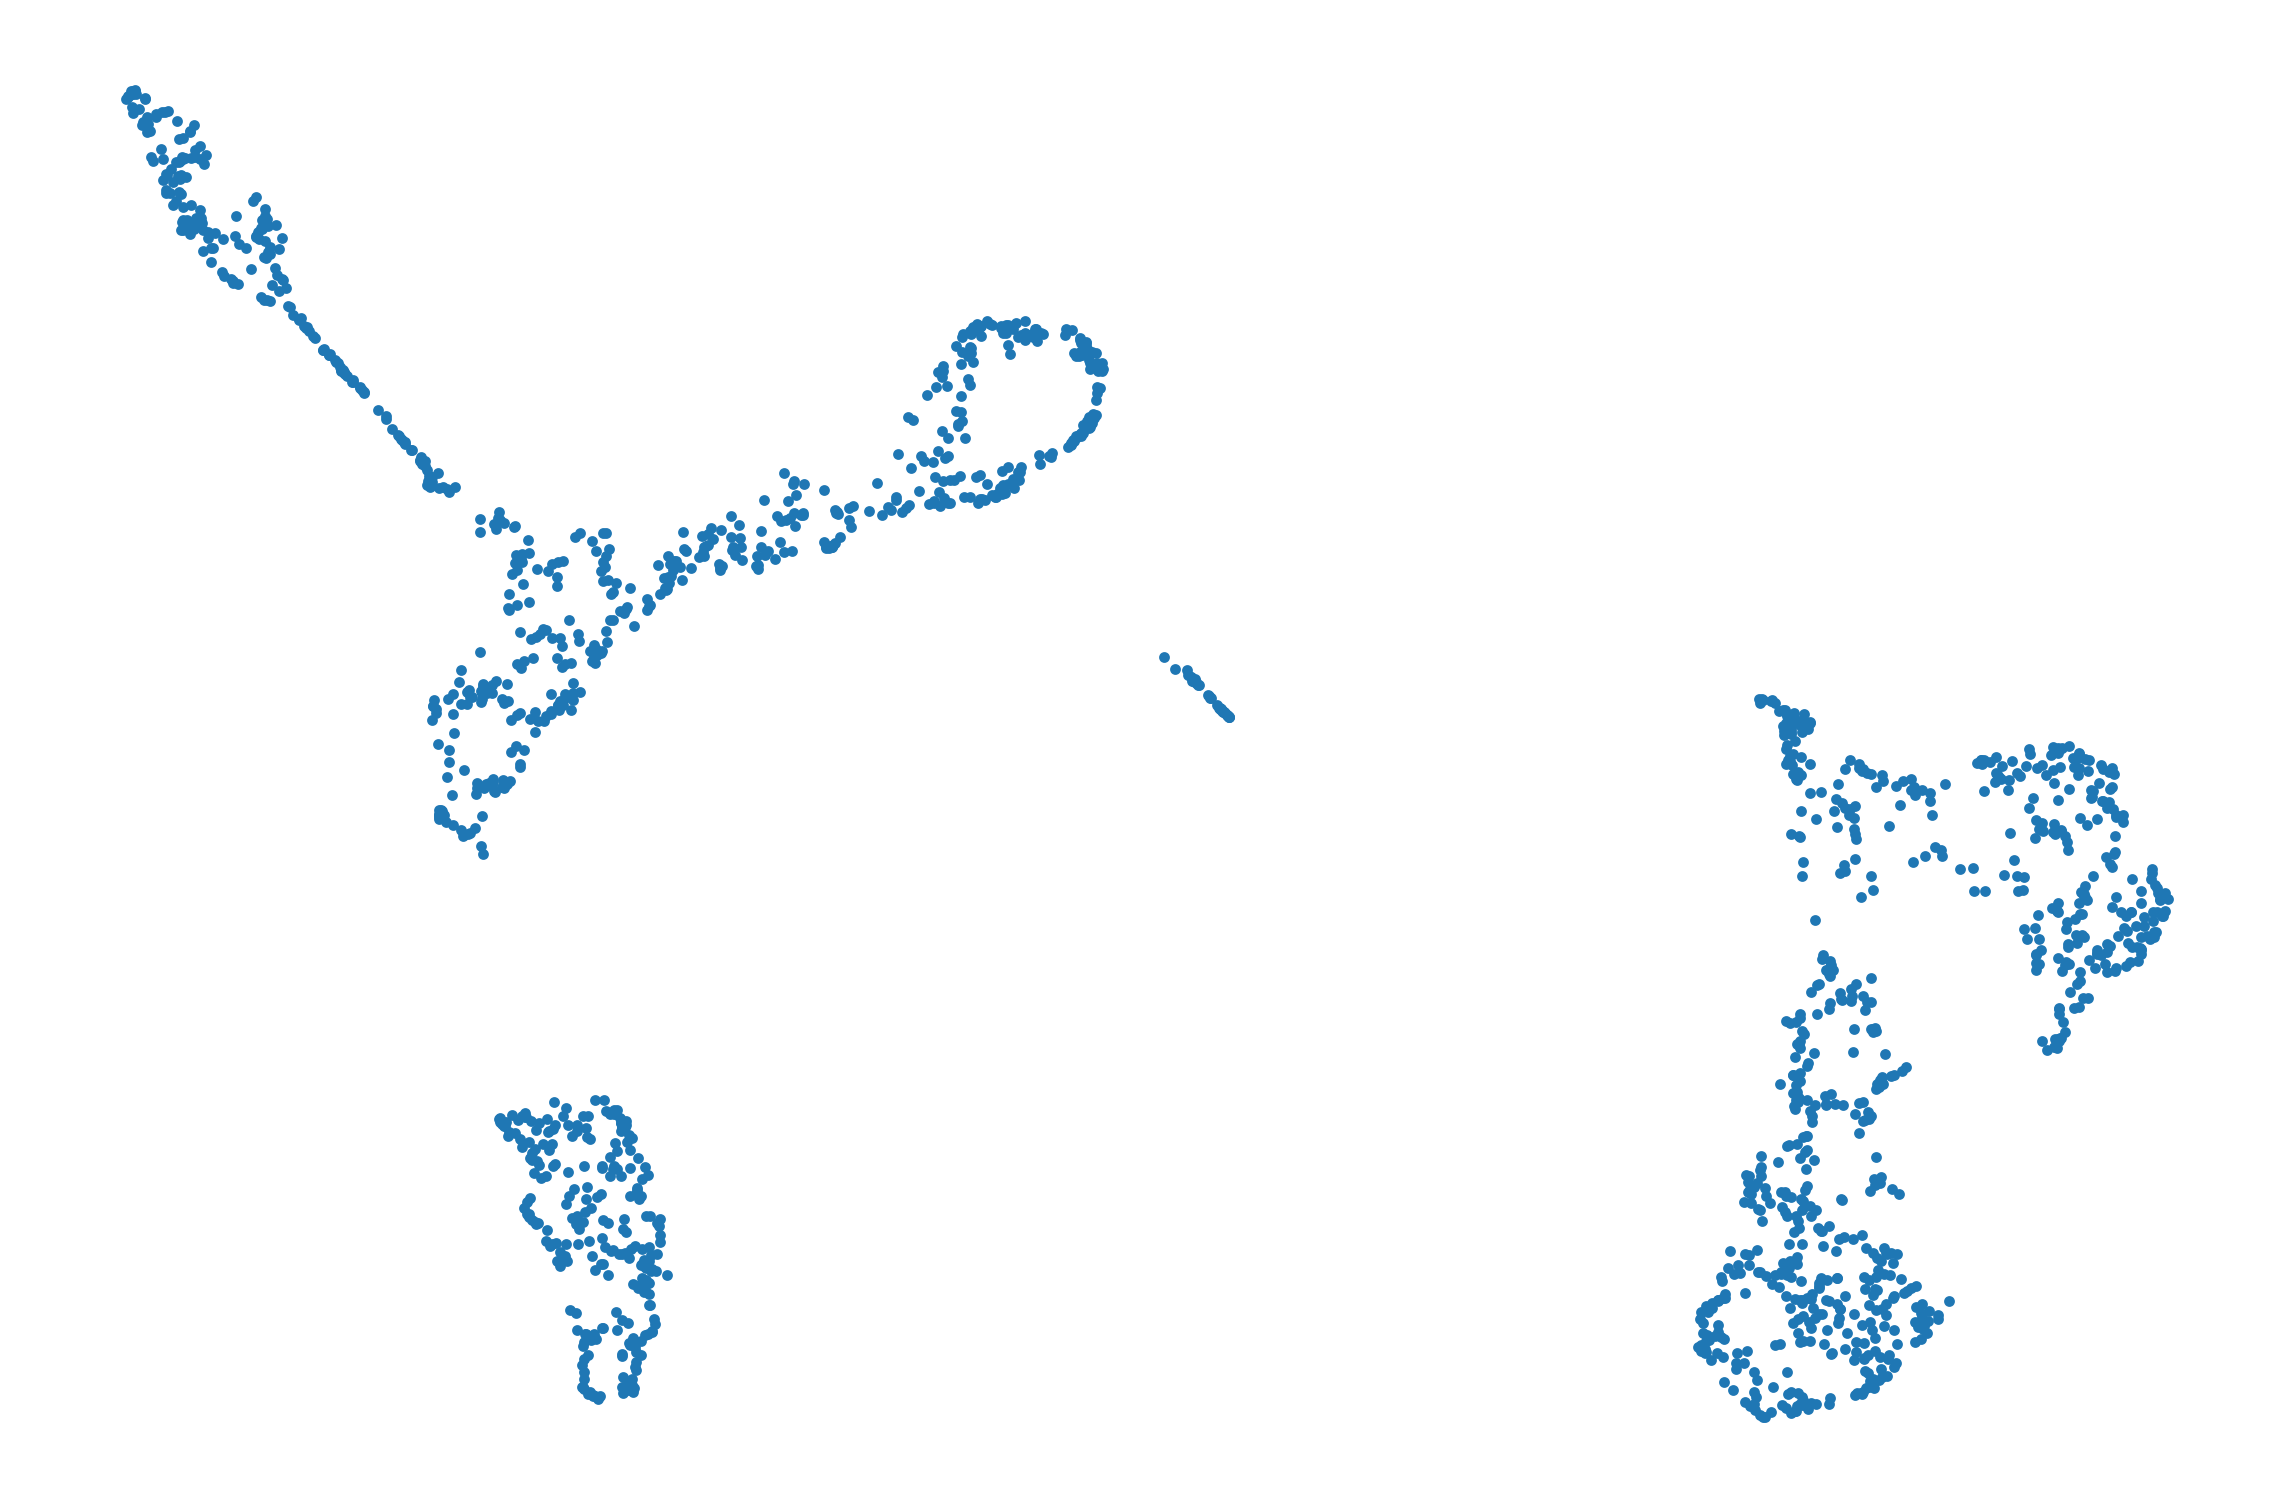

In [48]:
plot_embeddings(X_embedded, s=5)

In [49]:
import numpy as np

from sklearn.neighbors import NearestNeighbors

from models.ti.connectivity import compute_directed_cluster_connectivity, compute_undirected_cluster_connectivity
from models.ti.graph import compute_trajectory_graph, compute_connectivity_graph
from utils.plot import plot_connectivity_graph, plot_trajectory_graph, plot_connectivity_graph_with_gene_expressions
from utils.util import get_start_cell_cluster_id

In [50]:
communities = preprocessed_data.obs['metric_clusters'].to_numpy().astype(int)

In [51]:
X = preprocessed_data.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [52]:
start_cell_ids = preprocessed_data.uns['start_id']
start_cluster_ids = get_start_cell_cluster_id(preprocessed_data, start_cell_ids, communities)
start_cluster_ids

{1, 7}

In [53]:
un_connectivity, un_z_score = compute_undirected_cluster_connectivity(communities, adj_conn, z_threshold=0.6)
pd.DataFrame(un_z_score)

Runtime for compute_undirected_cluster_connectivity(): 0.1413438320159912


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,-1.150477,-1.137776,5.973295,-1.130738,-1.120149,0.319049,-1.134098,-1.136954,-1.134302,-1.132596,-1.131670,-1.136070
1,-1.150477,0.000000,-1.122641,-1.004792,-1.108009,-1.091853,-1.078941,-1.059656,1.751053,5.505709,-1.098127,4.724068,0.215010
2,-1.137776,-1.122641,0.000000,-0.926206,-1.111000,-1.104848,-1.110712,0.068062,-1.109538,5.563762,-1.106826,-1.105261,1.089341
3,5.973295,-1.004792,-0.926206,0.000000,-1.097975,-1.091063,0.959273,1.425084,-1.083760,-0.842466,-1.078790,-1.072454,-0.997045
4,-1.130738,-1.108009,-1.111000,-1.097975,0.000000,-1.091608,-1.091241,-1.087810,10.709871,-1.086219,-1.085077,-1.081921,-1.081617
5,-1.120149,-1.091853,-1.104848,-1.091063,-1.091608,0.000000,-1.086318,-1.083607,-1.083575,-0.946216,-1.081439,9.582561,-1.020049
6,0.319049,-1.078941,-1.110712,0.959273,-1.091241,-1.086318,0.000000,0.386734,-1.074438,-1.072094,9.394337,-1.064672,-1.061225
7,-1.134098,-1.059656,0.068062,1.425084,-1.087810,-1.083607,0.386734,0.000000,-1.068020,-1.046776,5.794360,-1.057850,4.675185
8,-1.136954,1.751053,-1.109538,-1.083760,10.709871,-1.083575,-1.074438,-1.068020,0.000000,-1.063853,-1.062425,-1.054877,-1.048846
9,-1.134302,5.505709,5.563762,-0.842466,-1.086219,-0.946216,-1.072094,-1.046776,-1.063853,0.000000,-1.060336,-0.987907,0.435177


Runtime for compute_connectivity_graph(): 0.009389638900756836


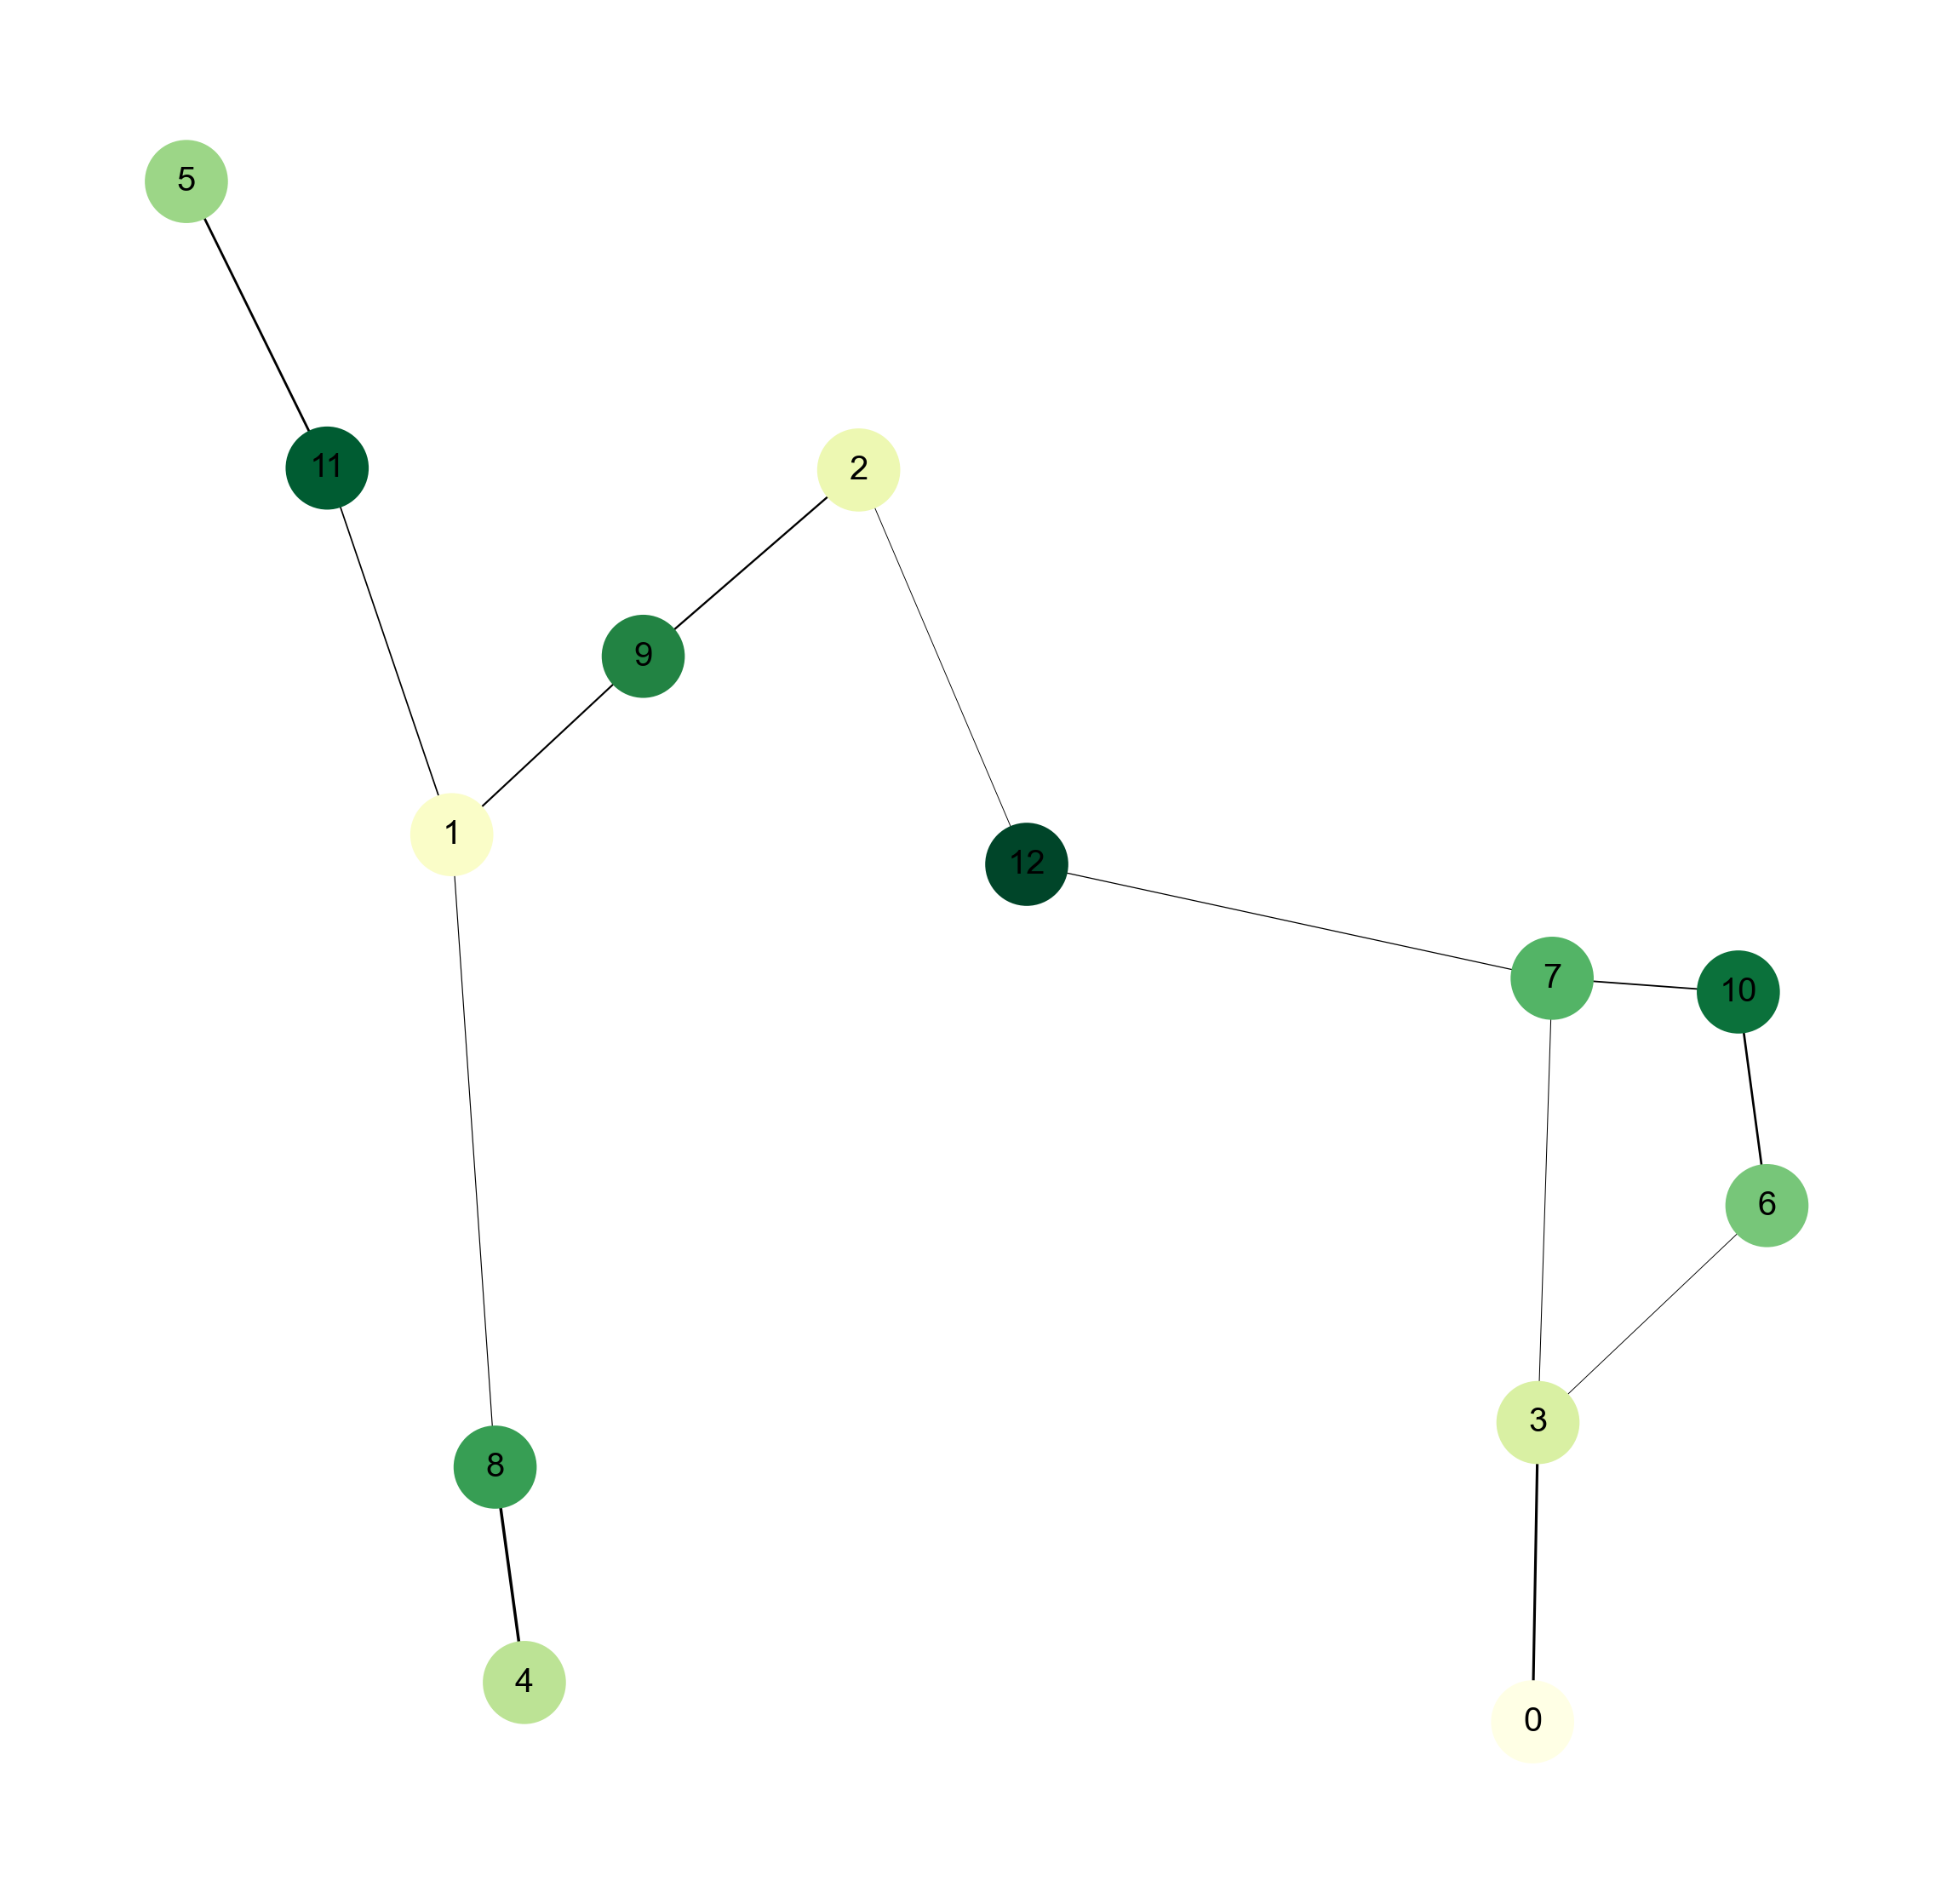

In [54]:
plot_connectivity_graph(preprocessed_data.obsm['X_met_embedding'], communities, un_connectivity, mode='undirected', offset=0.2)

In [55]:
connectivity, z_score = compute_directed_cluster_connectivity(communities, adj_conn, threshold=0.8)

Runtime for compute_directed_cluster_connectivity(): 0.06185340881347656


In [56]:
import networkx as nx

from sklearn.neighbors import NearestNeighbors

from models.ti.pseudotime import compute_pseudotime
from models.ti.pseudotime_v2 import compute_pseudotime
from models.ti.graph import compute_trajectory_graph_v2
from utils.plot import plot_trajectory_graph_v2
from utils.plot import plot_pseudotime

In [57]:
# v2 pseudotime
G_undirected, node_positions = compute_connectivity_graph(preprocessed_data.obsm['X_met_embedding'], preprocessed_data.obs['metric_clusters'], un_connectivity)
adj_cluster = nx.to_pandas_adjacency(G_undirected)
pseudotime = compute_pseudotime(preprocessed_data, start_cell_ids, adj_dist, adj_cluster)

Runtime for compute_connectivity_graph(): 0.007861852645874023
Runtime for compute_pseudotime(): 0.3282194137573242


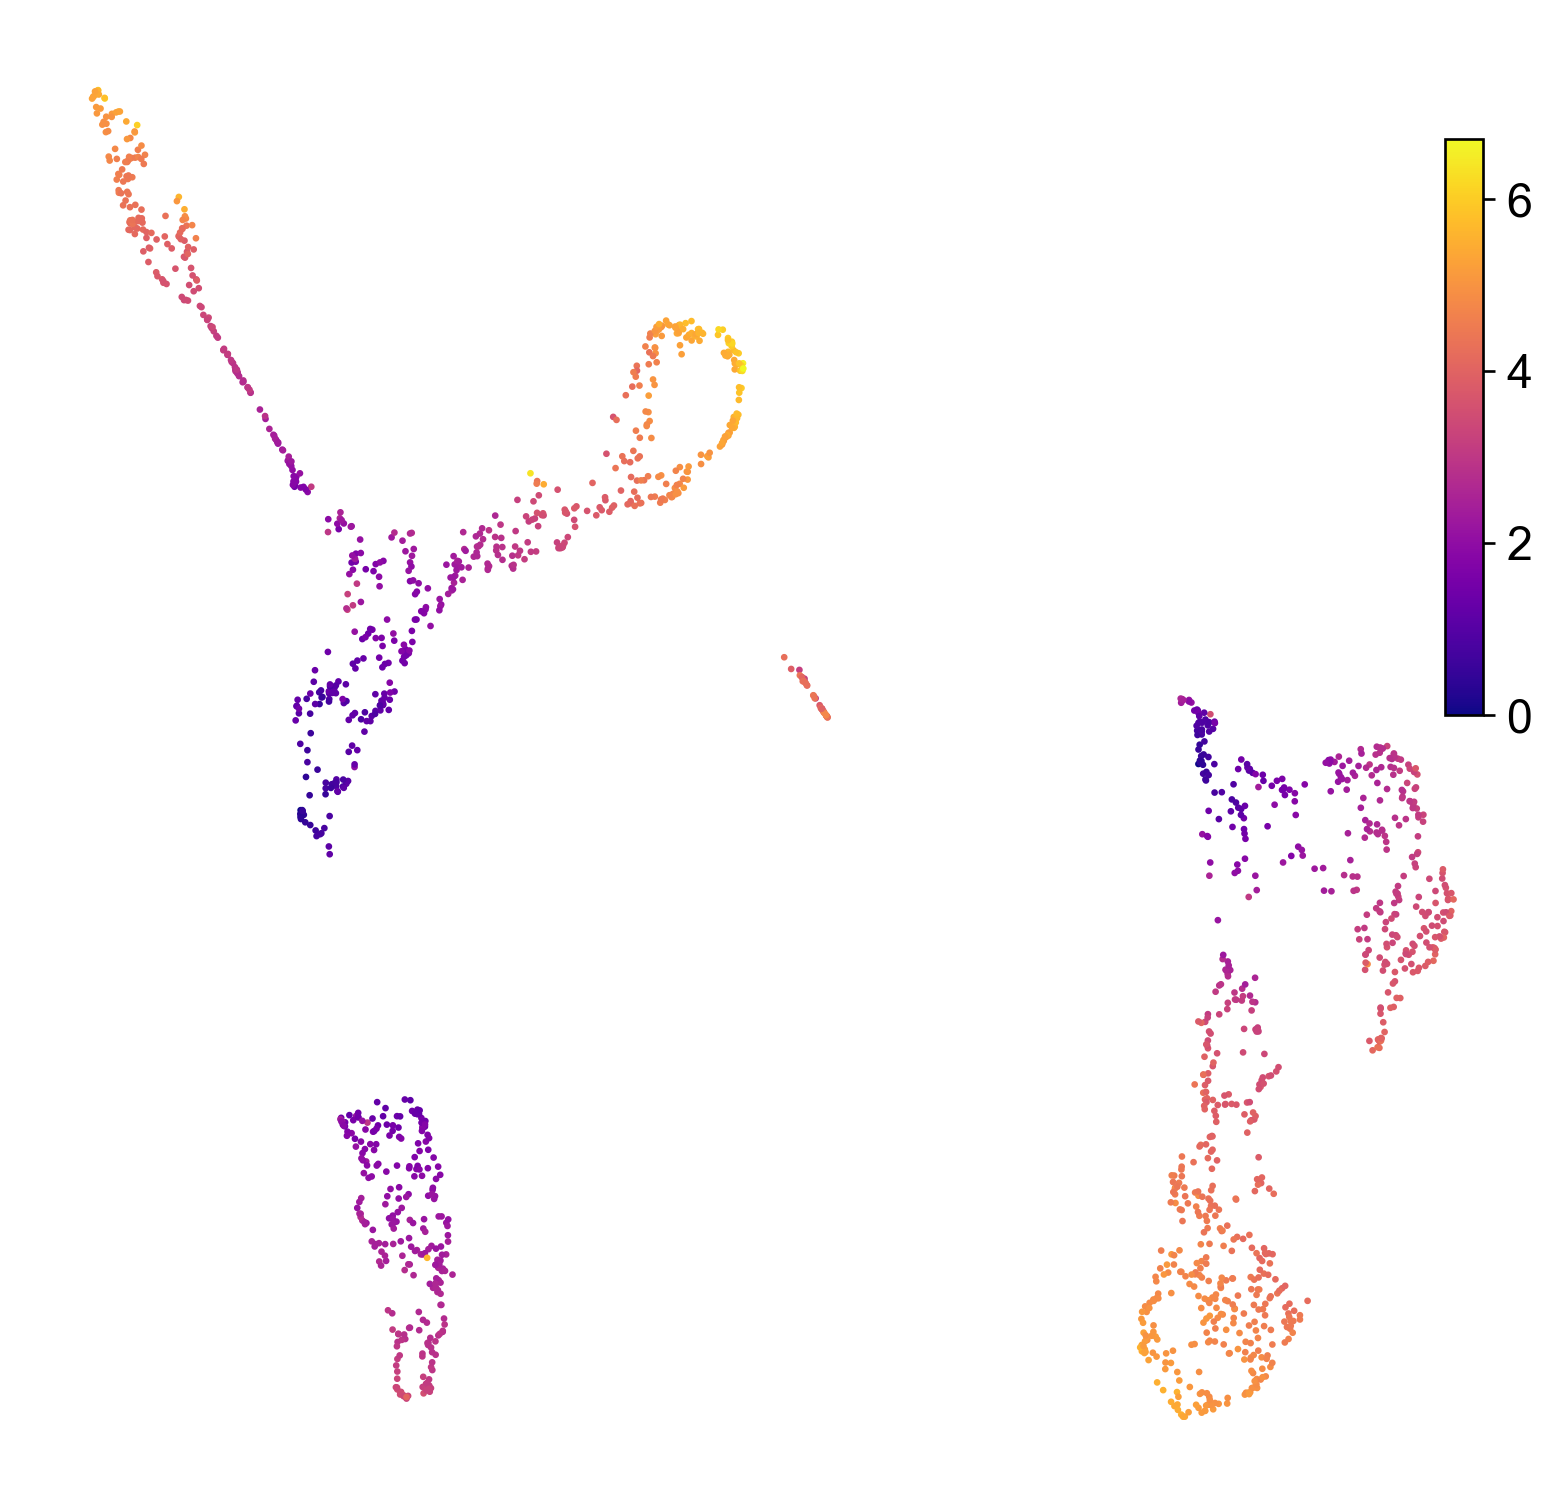

In [58]:
plot_pseudotime(
    preprocessed_data,
    embedding_key="X_met_embedding",
    pseudotime_key="metric_pseudotime_v2",
    s=1,
    cmap='plasma',
    figsize=(8, 8),
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3]
)

In [59]:
# Compute directed graph v2
G_directed_v2 = compute_trajectory_graph_v2(pseudotime, adj_cluster, preprocessed_data.obs['metric_clusters'], connectivity)

Runtime for compute_trajectory_graph_v2(): 0.015454292297363281


In [60]:
color_map = {
    0: '#FA6B66',
    1: '#A6A78F',
    2: '#A6A78F',
    3: '#A6A78F',
    4: '#A6A78F',
    5: '#6EAAAF',
    6: '#6EAAAF',
    7: '#6EAAAF',
    8: '#6EAAAF',
    9: '#6EAAAF',
    10: '#A6A78F'
}
color_map = {f'{idx}': '#A6A78F' for idx in range(22)}
color_map['16'] = '#FA6B66'
color_map['1'] = '#FA6B66'
color_map['0'] = '#FA6B66'

color_map['18'] = '#6EAAAF'
color_map['11'] = '#6EAAAF'
color_map['17'] = '#6EAAAF'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


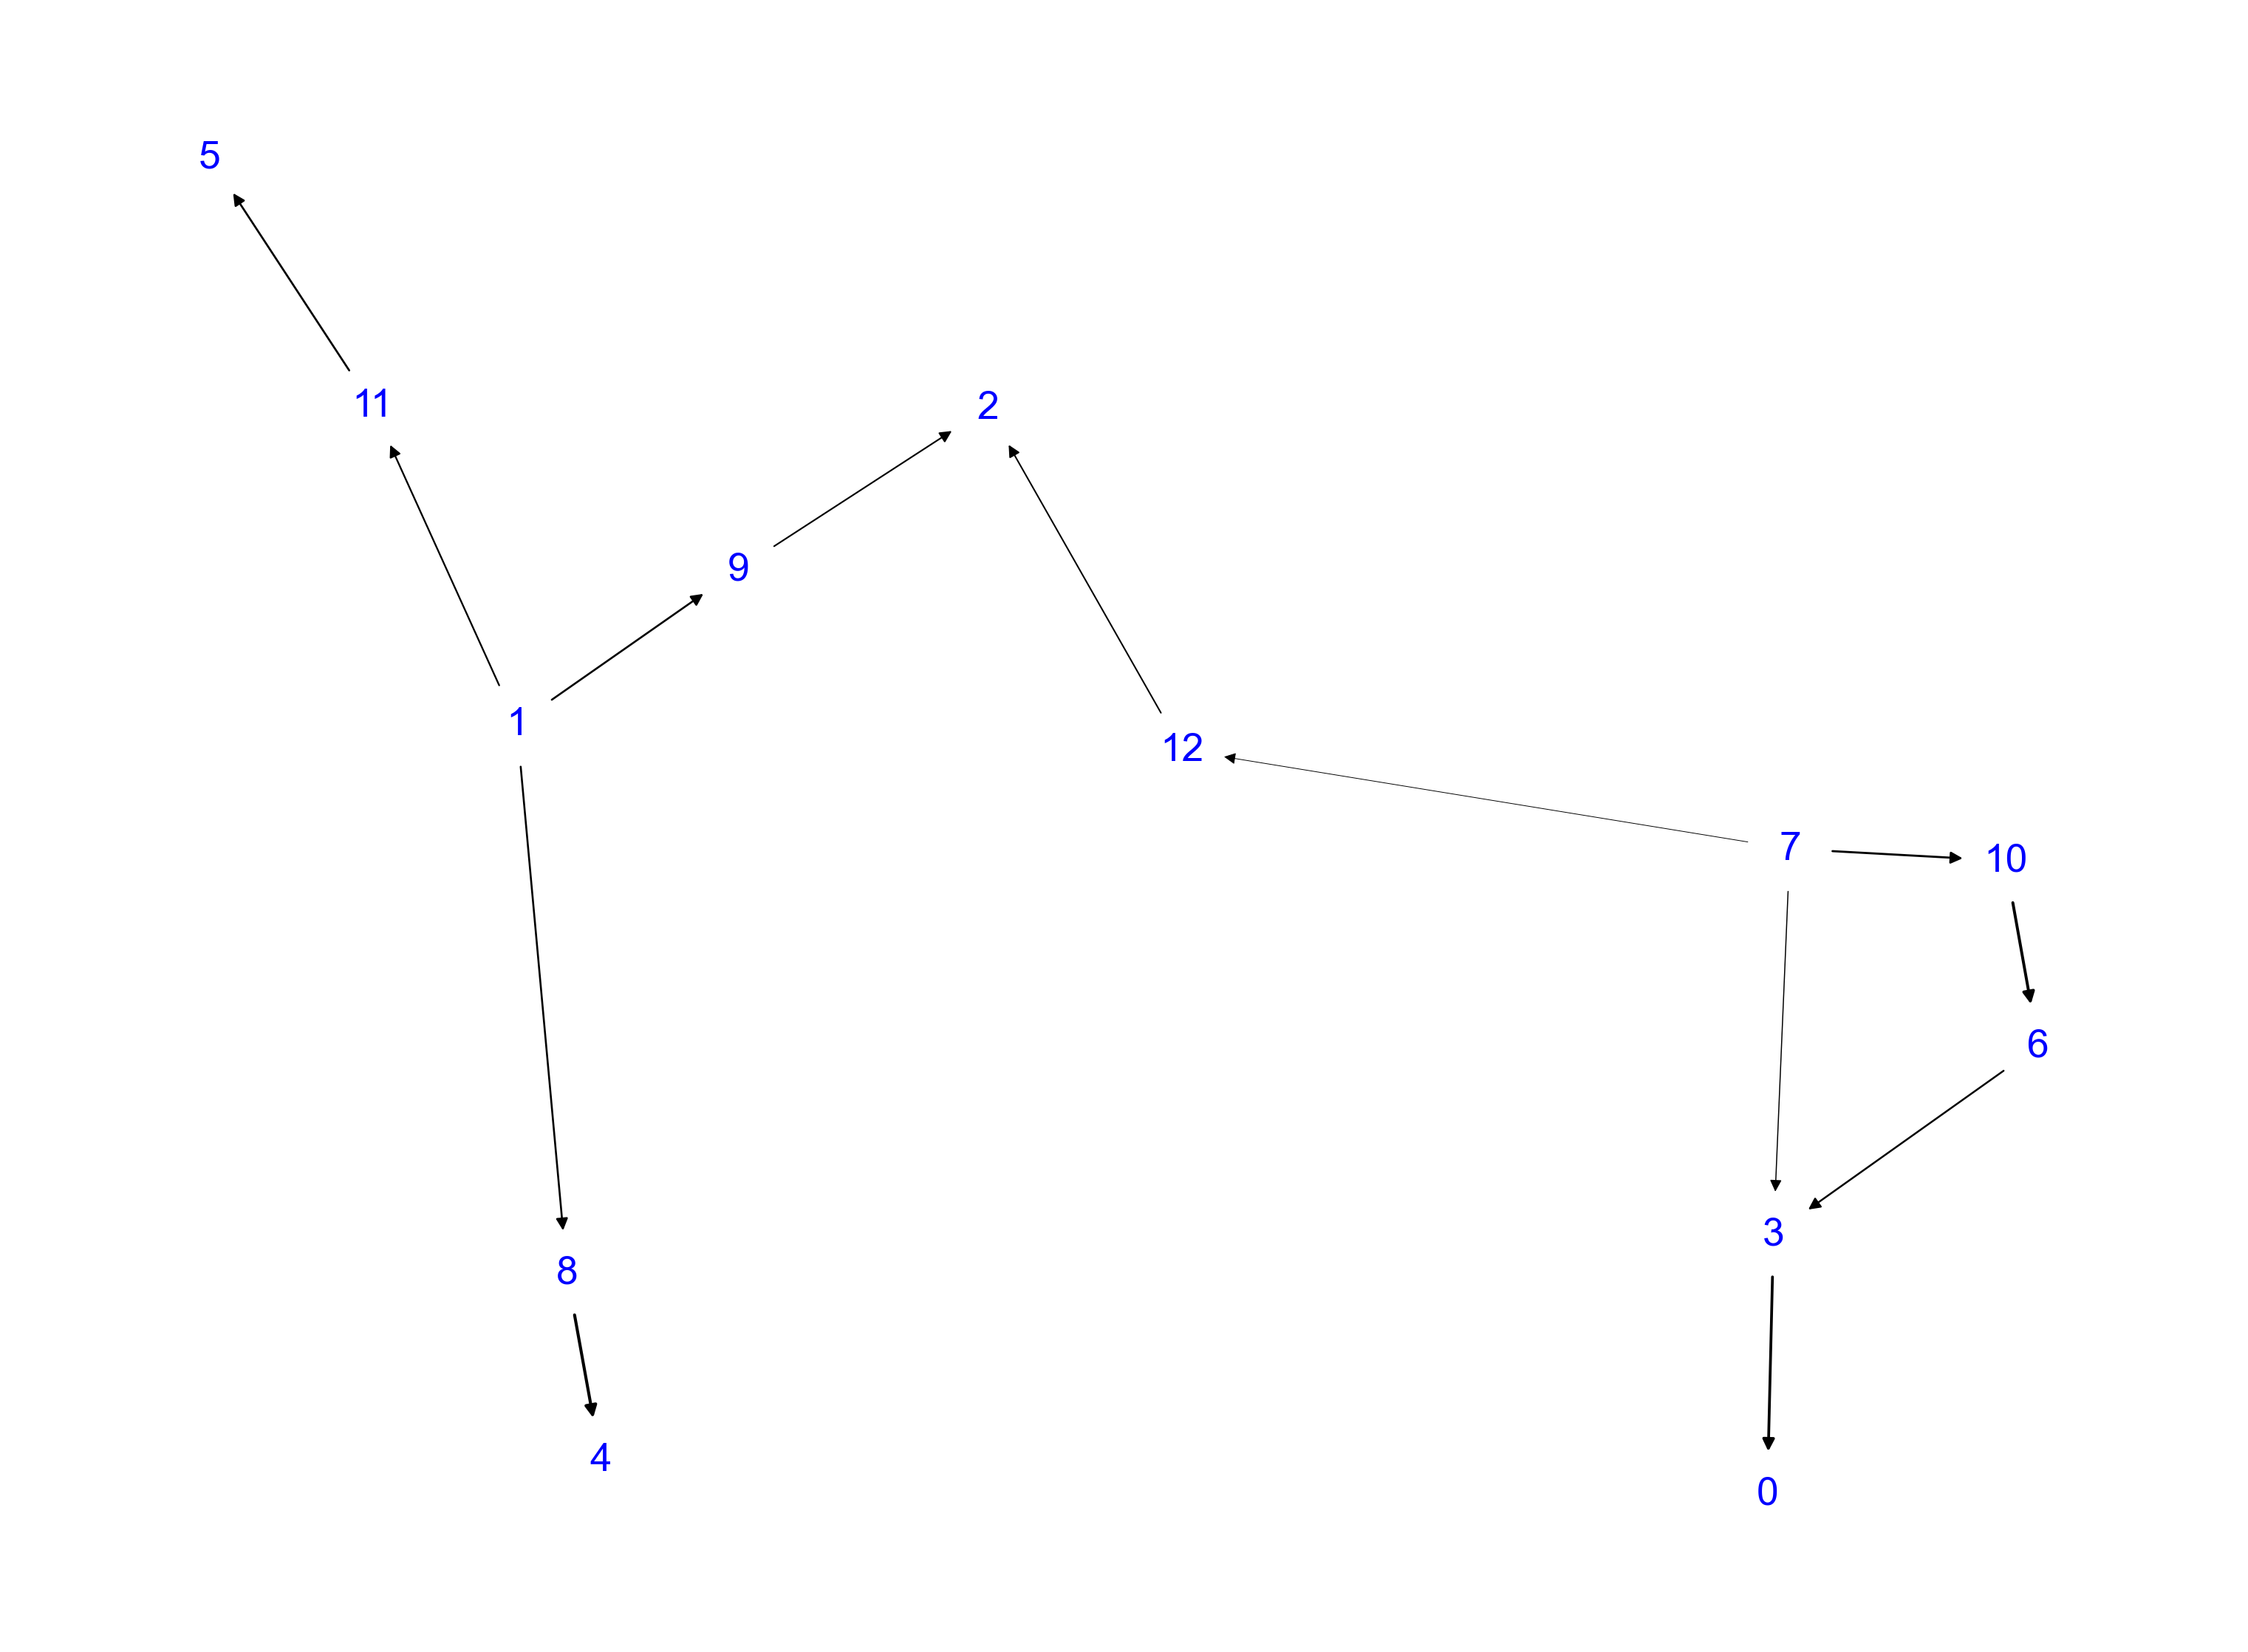

In [61]:
from utils.plot import plot_graph

g = nx.from_pandas_adjacency(G_directed_v2, create_using=nx.DiGraph)

print(g.nodes())

node_keys = list(node_positions.keys())  # Should be the same as g.nodes()
colors = [color_map[node] for node in node_keys if node in color_map]

plot_graph(
    g,
    node_positions=node_positions,
    figsize=(16, 12),
    offset=0.2,
    node_color=colors,
    font_size=16,
    font_color='blue',
    node_size=1200
)

In [62]:
print(g)

DiGraph with 13 nodes and 13 edges


In [63]:
from models.ti.downstream import (
    get_terminal_states,
    get_terminal_cells,
    sample_waypoints,
    compute_diff_potential,
)

In [64]:
X = preprocessed_data.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [65]:
# Terminal state computation

start_cell_ids = preprocessed_data.uns['start_id']
get_terminal_states(preprocessed_data, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

Terminal cluster candidate 1: {0, 2, 4, 5}
Terminal cluster candidate 2: {0, 1, 2, 4, 5, 7}
Terminal clusters: {0, 2, 4, 5}


{0, 2, 4, 5}

In [66]:
# Ensure terminal states are computed before accessing terminal cells
if 'metric_terminal_clusters' not in preprocessed_data.uns:
	start_cell_ids = preprocessed_data.uns['start_id']
	get_terminal_states(preprocessed_data, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

# Terminal cell computation
t_cell_ids = get_terminal_cells(preprocessed_data)
t_cell_ids

['Placenta_2.ACTTATCCGACGTACTTC',
 'Placenta_2.GAGGAGAAGTACGCGAAT',
 'Placenta_2.TGCAATTTTAGGTAGCAT',
 'Placenta_2.CTCGCATCACTTGAATTA']

In [67]:
# Waypoint computation
from models.ti.downstream import sample_waypoints


dists, wp = sample_waypoints(preprocessed_data, adj_dist.todense(), n_waypoints=30)

/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dists.loc[cell_ids, k] = v
/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dists.loc[cell_ids, k] = v
/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

In [68]:
# Compute entropy and diff potential

ent, bps = compute_diff_potential(
    preprocessed_data,
    adj_dist.todense(),
    adj_cluster,
    std_factor=0,
    prune_wp_graph=True
)

Cell to Waypoint connectivity
Waypoint to Terminal State connectivity
Markov chain construction...
Computing fundamental matrix and absorption probabilities...


/home/satwik/dynooenv/lib/python3.12/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


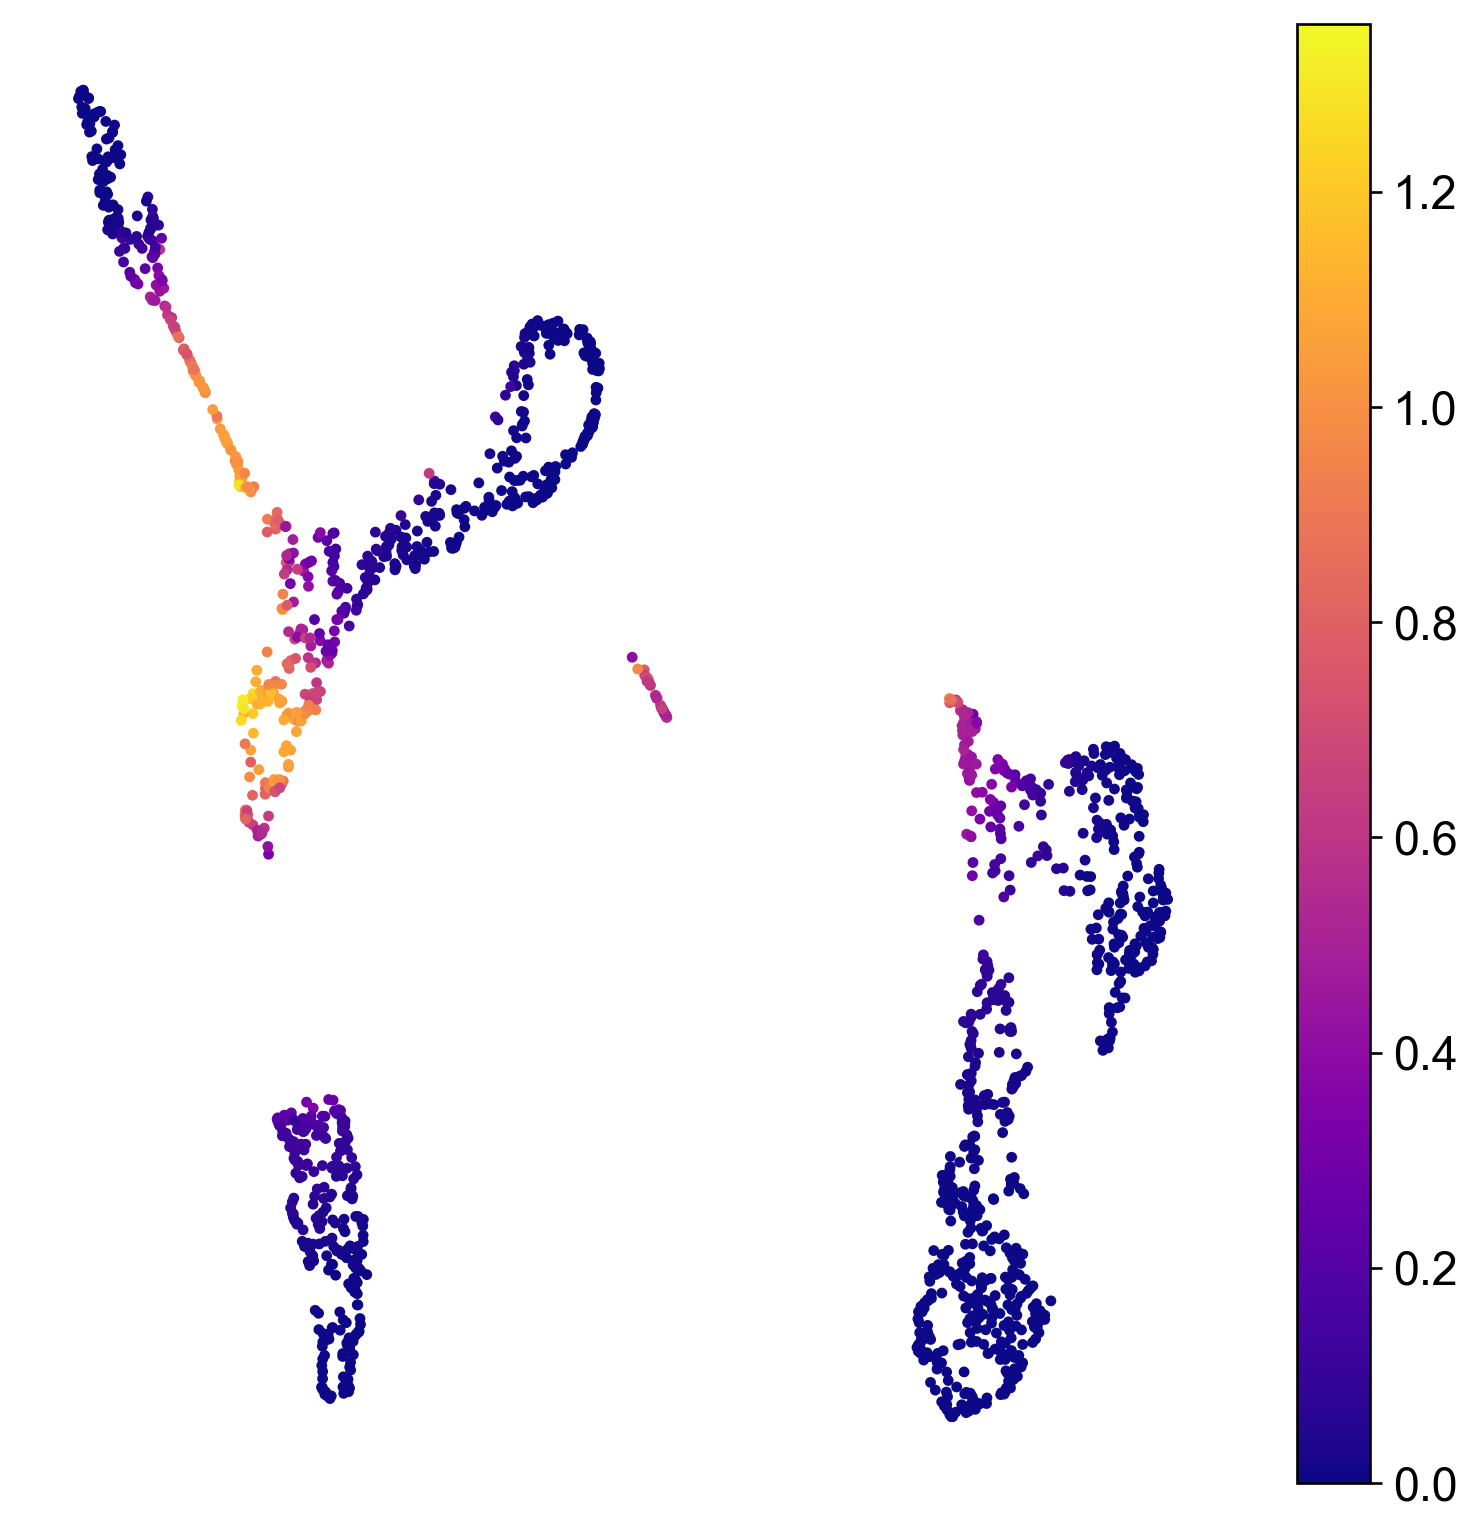

In [69]:
# Plot the Differentiation potential
plot_embeddings(
    preprocessed_data.obsm['X_met_embedding'],
    s=5,
    c=ent,
    figsize=(8, 8),
    cmap='plasma',
    show_colorbar=True
)

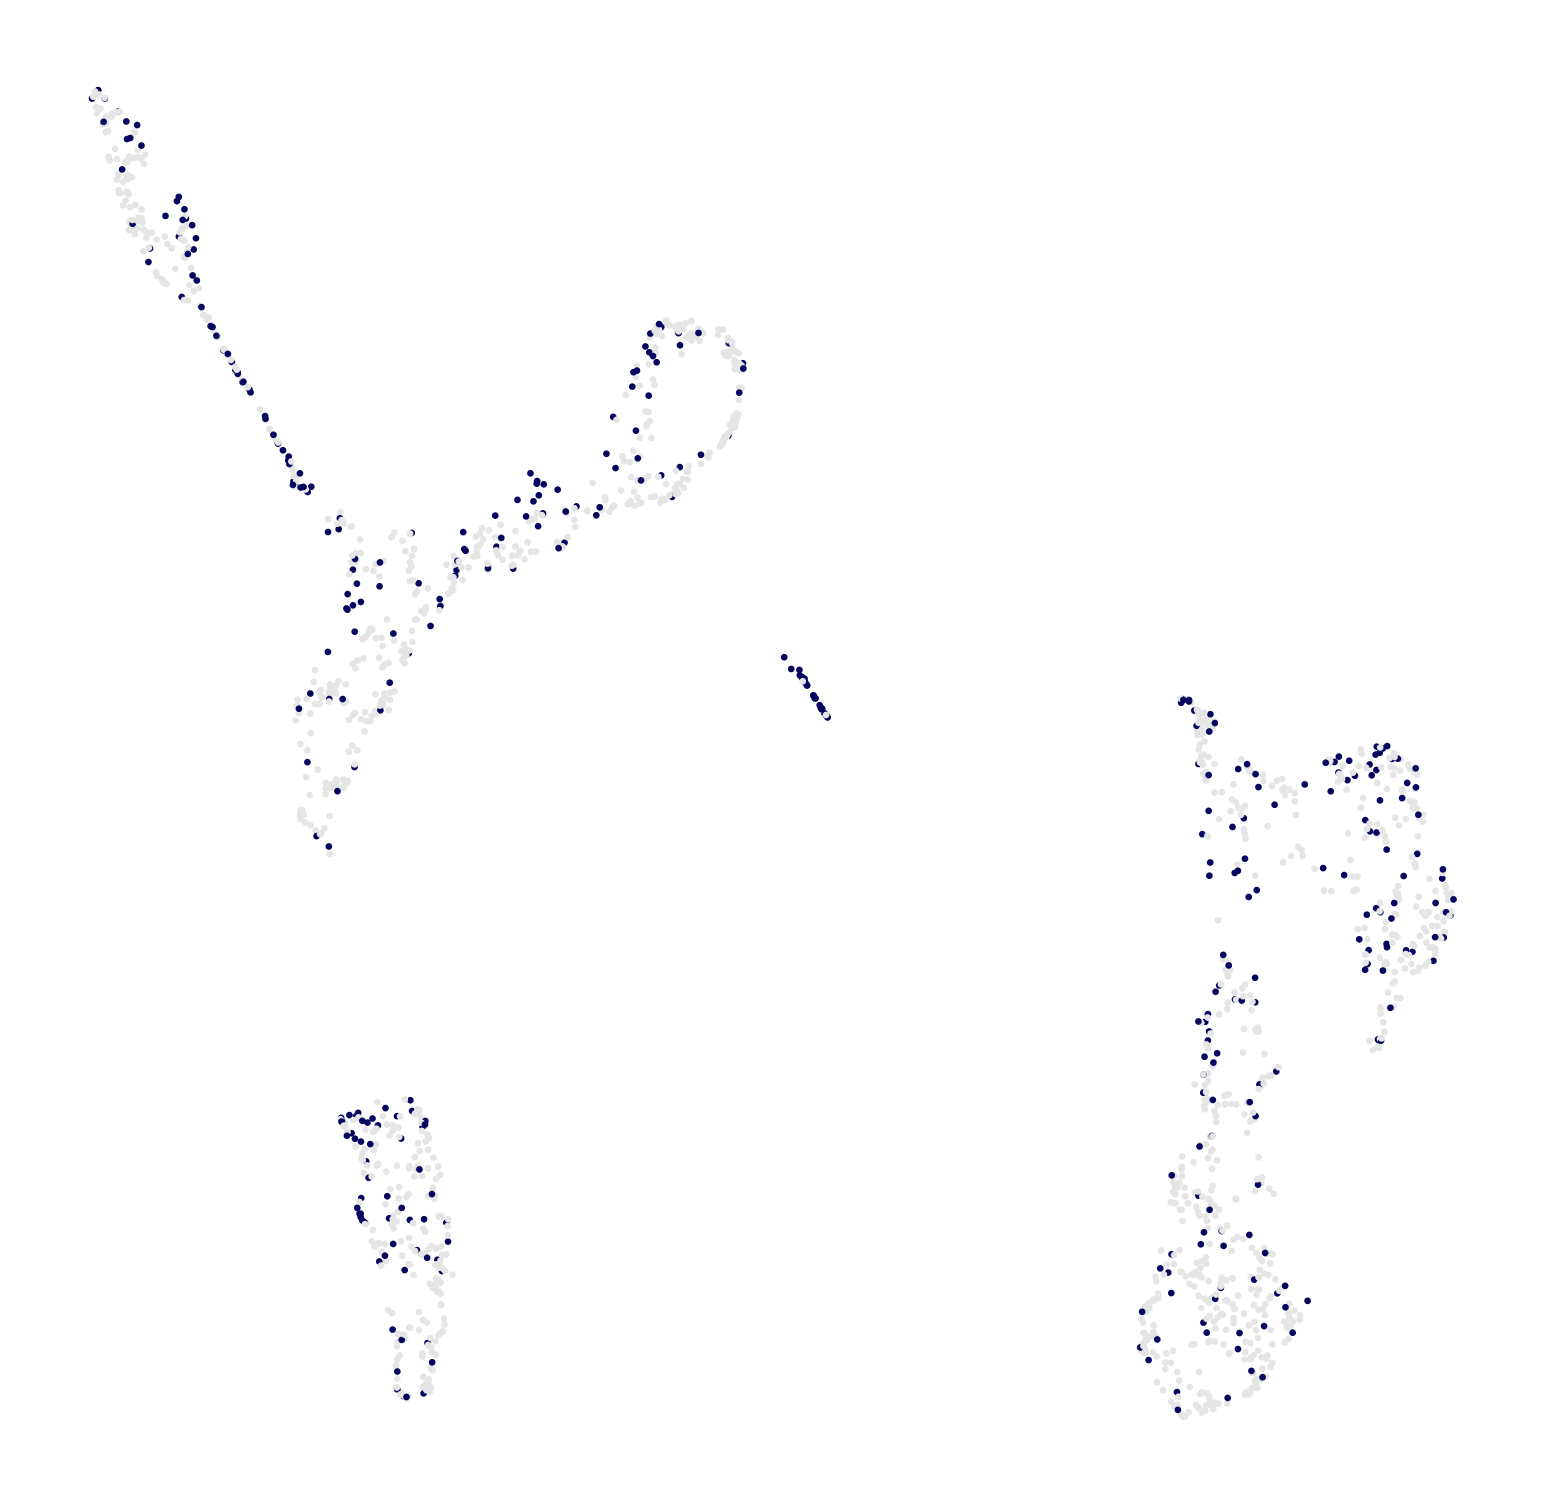

In [70]:
# Plot the sampled waypoints
colors = ['#03045E' if cell_id in preprocessed_data.uns['metric_waypoints'] else '#E5E5E5' for cell_id in preprocessed_data.obs_names]
plot_embeddings(
    preprocessed_data.obsm['X_met_embedding'],
    s=1,
    c=colors,
    figsize=(8, 8)
)

In [71]:
import scipy.stats as ss

ss.spearmanr(preprocessed_data.obs['metric_dp'], adata.uns['timecourse']['pt'])

SignificanceResult(statistic=-0.5392063843357551, pvalue=7.898902166658289e-132)

# Margaret metrics

In [72]:
cell_ids = preprocessed_data.obs_names.tolist()
m_pseudotime = preprocessed_data.obs['metric_pseudotime_v2']
m_pseudotime.name = 'pseudotime'
m_milestone_ids = sorted(preprocessed_data.obs['metric_clusters'].unique())
m_milestone_ids = [str(i) for i in m_milestone_ids]
m_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': list(preprocessed_data.obs['metric_clusters']), 'percentage': [1 for i in range(len(cell_ids))]})
m_milestone_percentages['milestone_id'] = m_milestone_percentages['milestone_id'].astype(str)
m_milestone_percentages

,cell_id,milestone_id,percentage
0,Placenta_1.AAGCGGAGGGTCAAGCGG,6,1
1,Placenta_1.CGAGTAAGTCGTCATGAT,6,1
2,Placenta_1.CGCACCTATTGTGGTACA,10,1
3,Placenta_1.AGGACTGCCCTCTATGTA,6,1
4,Placenta_1.GGACATGGACATTGATCA,6,1
...,...,...,...
1735,Placenta_2.GACACTTCGTAACTGAAA,9,1
1736,Placenta_2.TCGGGTTCACTTCAAAGT,1,1
1737,Placenta_2.AGTTTAATGGCGGCCTAG,3,1
1738,Placenta_2.TTGGACCGCACCGGCTGC,1,1


In [73]:
G = nx.from_pandas_adjacency(G_directed_v2, create_using=nx.DiGraph)
m_edges_df = nx.to_pandas_edgelist(G).rename(columns={'source': 'from', 'target': 'to'})
m_edges_df['length'] = 1  # no weights stored, use default for now
m_edges_df['directed'] = True
m_edges_df['from'] = m_edges_df['from'].astype(str)
m_edges_df['to'] = m_edges_df['to'].astype(str)
del m_edges_df['weight']
m_edges_df

,from,to,length,directed
0,1,8,1,True
1,1,9,1,True
2,1,11,1,True
3,3,0,1,True
4,6,3,1,True
5,7,3,1,True
6,7,10,1,True
7,7,12,1,True
8,8,4,1,True
9,9,2,1,True


In [74]:
disconnected = set(m_milestone_ids)
for i in m_edges_df['from']:
    disconnected.discard(i)
for i in m_edges_df['to']:  
    disconnected.discard(i)
disconnected = list(disconnected)
disconnected

[]

In [75]:
# new_rows = [{'from': i, 'to': i, 'length': 0, 'directed': True} for i in disconnected]
# m_edges_df = pd.concat([m_edges_df, pd.DataFrame(new_rows)], ignore_index=True)
# m_edges_df

In [76]:
# m_milestone_percentages.percentage.value_counts()

In [77]:
# progressions = pd.DataFrame({
#     'cell_id': cell_ids,
#     'from': [1 for i in range(len(cell_ids))],
#     'to': [1 for i in range(len(cell_ids))],
#     'percentage': [1 for i in range(len(cell_ids))]
# })
# progressions

In [78]:
# cell_to_milestone = dict(zip(m_milestone_percentages['cell_id'], m_milestone_percentages['milestone_id']))
# progressions['milestone'] = progressions['cell_id'].map(cell_to_milestone)
# progressions

In [79]:
# import random

# # Iterate through each row in the progressions DataFrame
# for idx, row in progressions.iterrows():
#     milestone = row['milestone']
    
#     # Filter rows in the milestone_network (m_edges_df) where the milestone is in 'from' or 'to'
#     matching_rows = m_edges_df[(m_edges_df['from'] == milestone) | (m_edges_df['to'] == milestone)]
    
#     # Pick one row at random from the matching rows
#     selected_row = matching_rows.sample(n=1).iloc[0]
    
#     # Update the 'from' and 'to' columns in progressions
#     progressions.at[idx, 'from'] = selected_row['from']
#     progressions.at[idx, 'to'] = selected_row['to']
    
#     # Update the 'percentage' column based on whether the milestone was in 'from' or 'to'
#     if selected_row['from'] == milestone:
#         progressions.at[idx, 'percentage'] = 0
#     elif selected_row['to'] == milestone:
#         progressions.at[idx, 'percentage'] = 1

# progressions

In [80]:
# progressions.percentage.value_counts()

In [81]:
# del progressions['milestone']

In [82]:
%%R -i cell_ids -i m_pseudotime -i m_milestone_ids -i m_milestone_percentages -i m_edges_df

m_dataset <- readRDS("placenta-trophoblast-differentiation-invasive_mca.rds")

marg_traj <- add_trajectory(
    m_dataset,
    cell_ids = cell_ids,
    pseudotime = m_pseudotime,
    milestone_ids = m_milestone_ids,
    milestone_percentages = m_milestone_percentages,
    milestone_network = m_edges_df,
)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


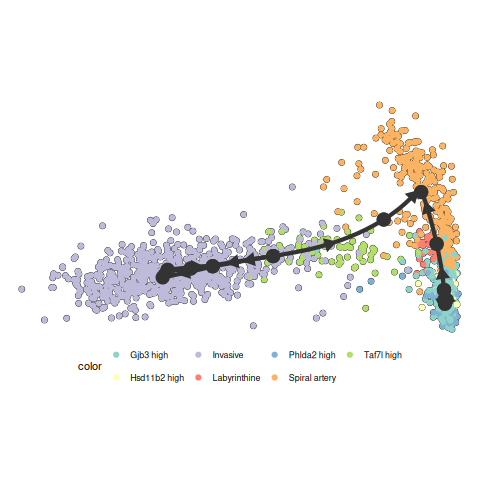

In [83]:
%%R
plot_dimred(marg_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [79]:
# %%R
# marg_traj$milestone_network <- marg_traj$milestone_network[marg_traj$milestone_network$length != 0, ]
# marg_traj$milestone_network

In [80]:
%%R
marg_metrics <- calculate_metrics(
  dataset = m_dataset,
  model = marg_traj,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = m_dataset$expression
)

In [81]:
%%R
cat("HIM =", marg_metrics$him, "\n")
cat("F1_branches =", marg_metrics$F1_branches, "\n")
cat("correlation =", marg_metrics$correlation, "\n")
cat("featureimp_wcor =", marg_metrics$featureimp_wcor, "\n")
m_selected_metrics <- c(
  him = as.numeric(marg_metrics$him),
  F1_branches = marg_metrics$F1_branches,
  correlation = marg_metrics$correlation,
  featureimp_wcor = marg_metrics$featureimp_wcor
)
m_overall_score <- exp(mean(log(m_selected_metrics)))
cat("overall_score =", m_overall_score, "\n")

HIM = 0.6732442 
F1_branches = 0.3555167 
correlation = 0.7649166 
featureimp_wcor = 0.9362518 
overall_score = 0.6434426 


# Palantir

In [101]:
import scanpy as sc
import palantir

%matplotlib inline

In [102]:
ad = adata.copy()
# sc.pp.normalize_per_cell(ad)

# from utils.util import log_transform

# log_transform(ad, pseudo_count=0.1)
# sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor='cell_ranger')
pca_projections, _ = palantir.utils.run_pca(ad, use_hvg=False)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [103]:
from utils.plot import generate_plot_embeddings, plot_embeddings

In [ ]:
X_dm = generate_plot_embeddings(ms_data, perplexity=150, method='tsne', random_state=0)

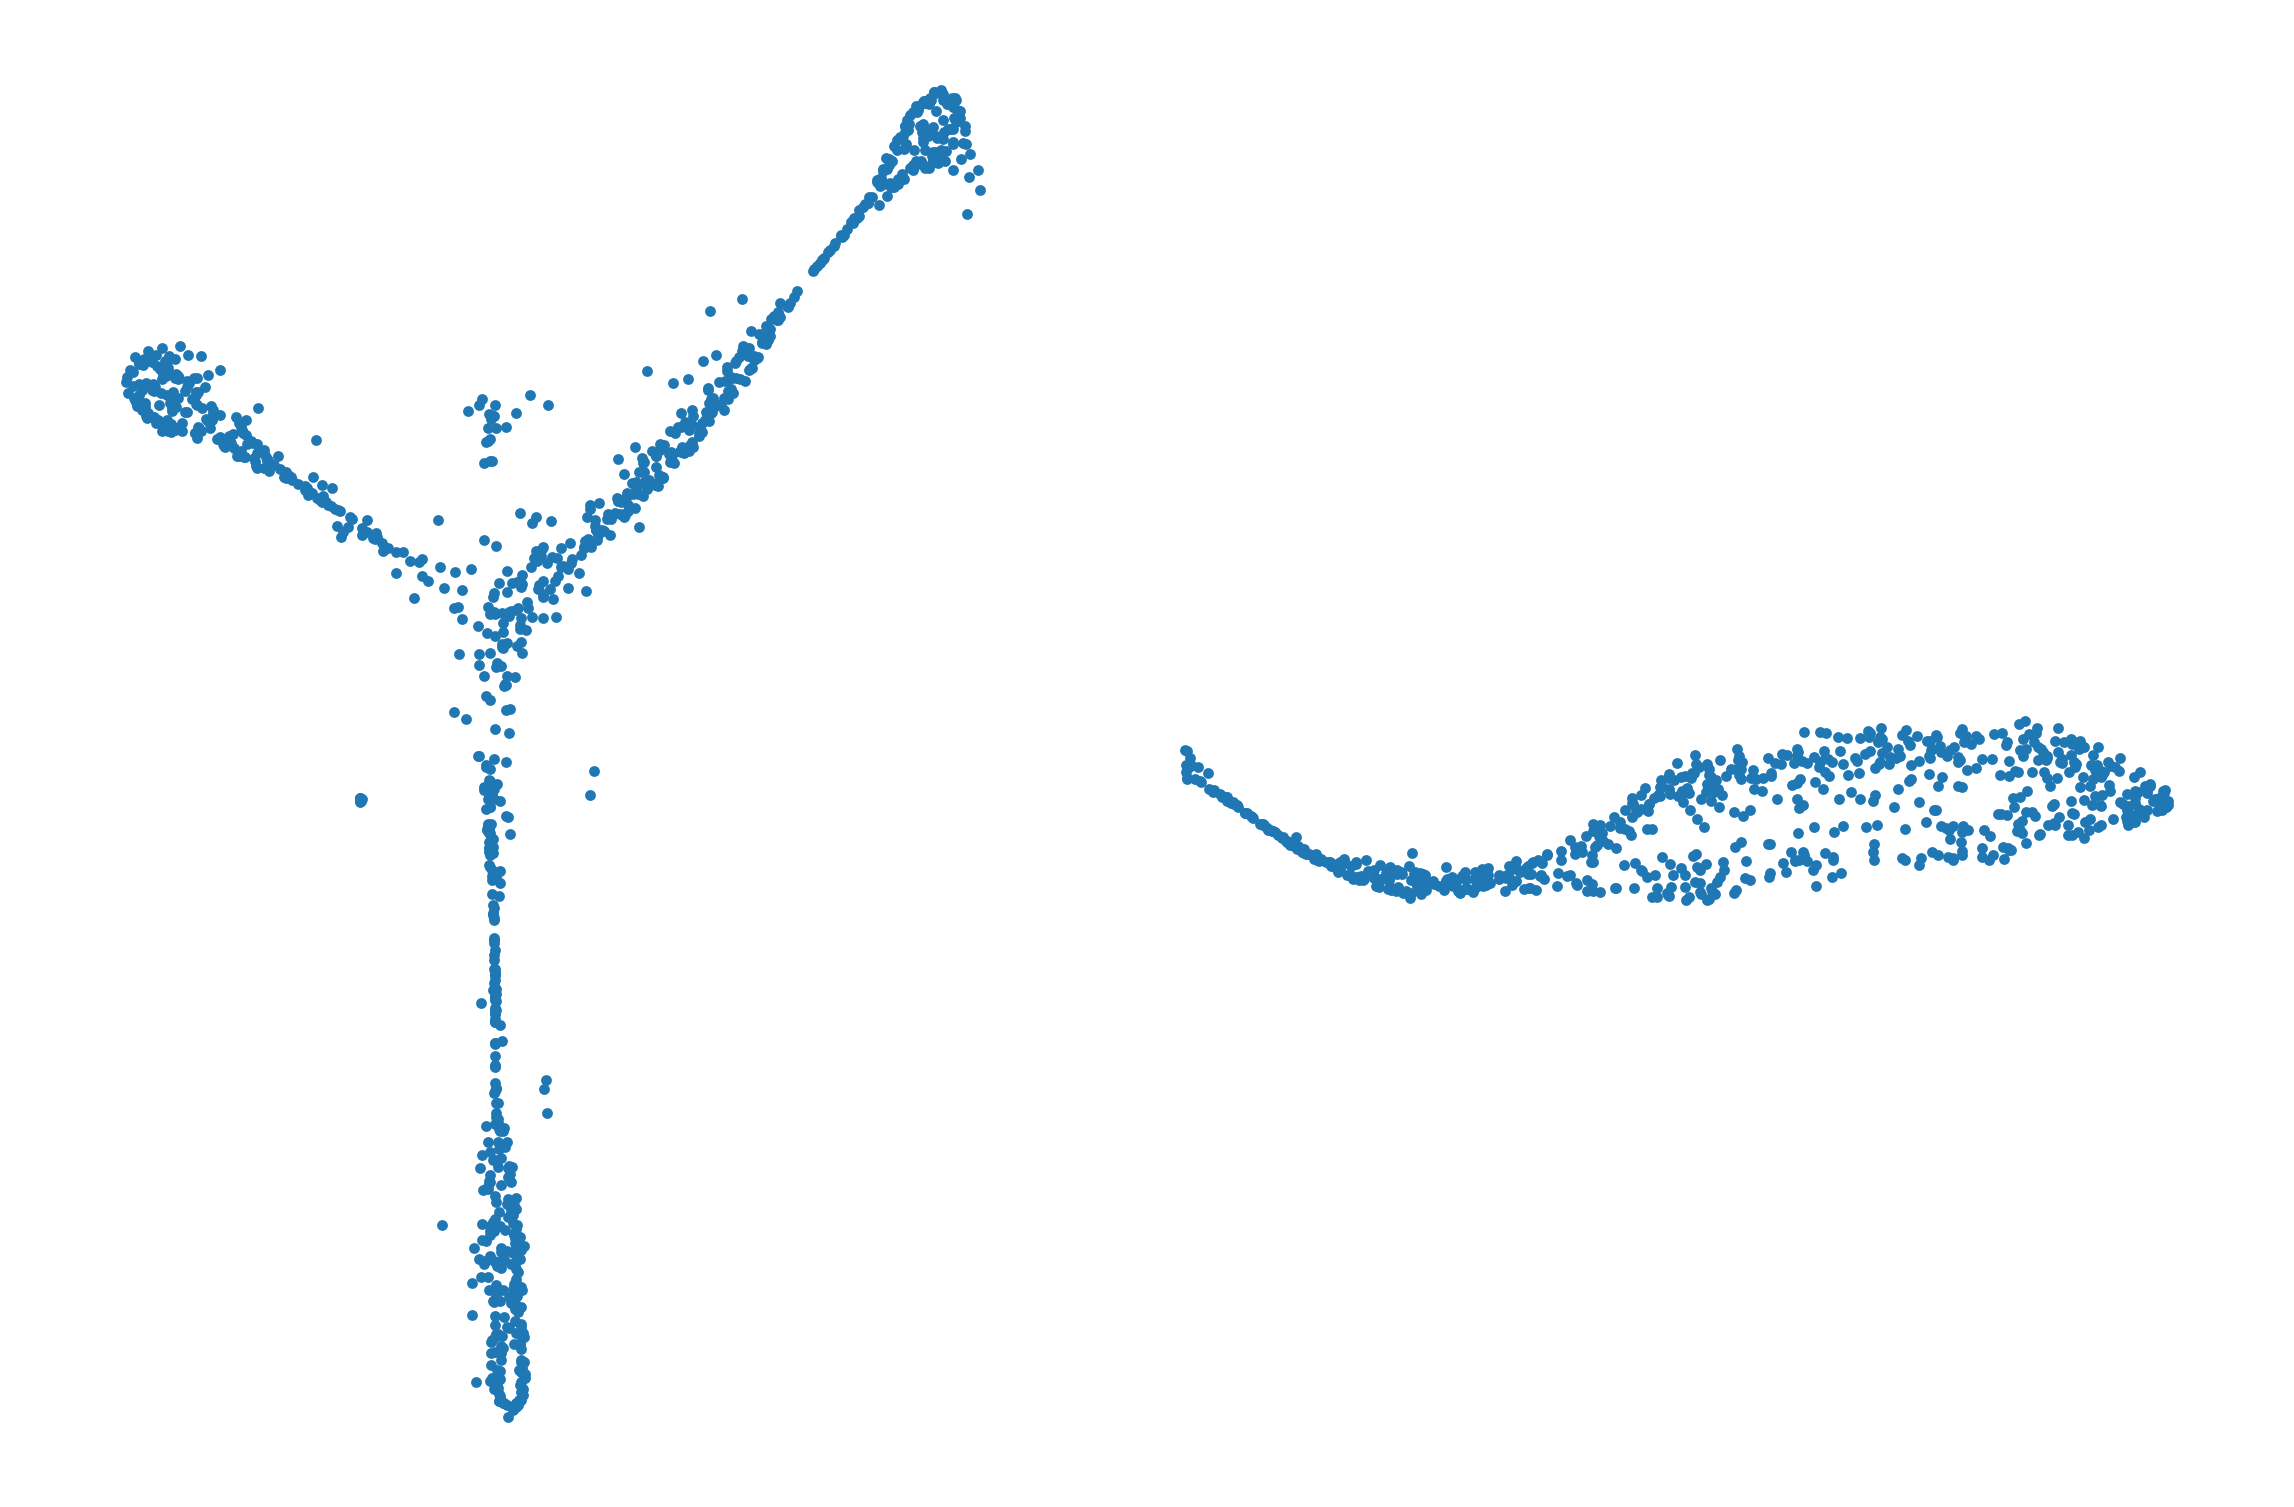

In [105]:
plot_embeddings(X_dm, s=5)

In [106]:
ad.uns['start_id']

array(['Placenta_2.ACTTATCCTAGATGTGCG', 'Placenta_1.GCGAATGCCCTCTTCCGC'],
      dtype=object)

In [ ]:
early_cell = ad.uns['start_id'][0]
# early_cell = ad.uns['start_id'][1]
presults = palantir.core.run_palantir(ms_data, early_cell)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0029206275939941406 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


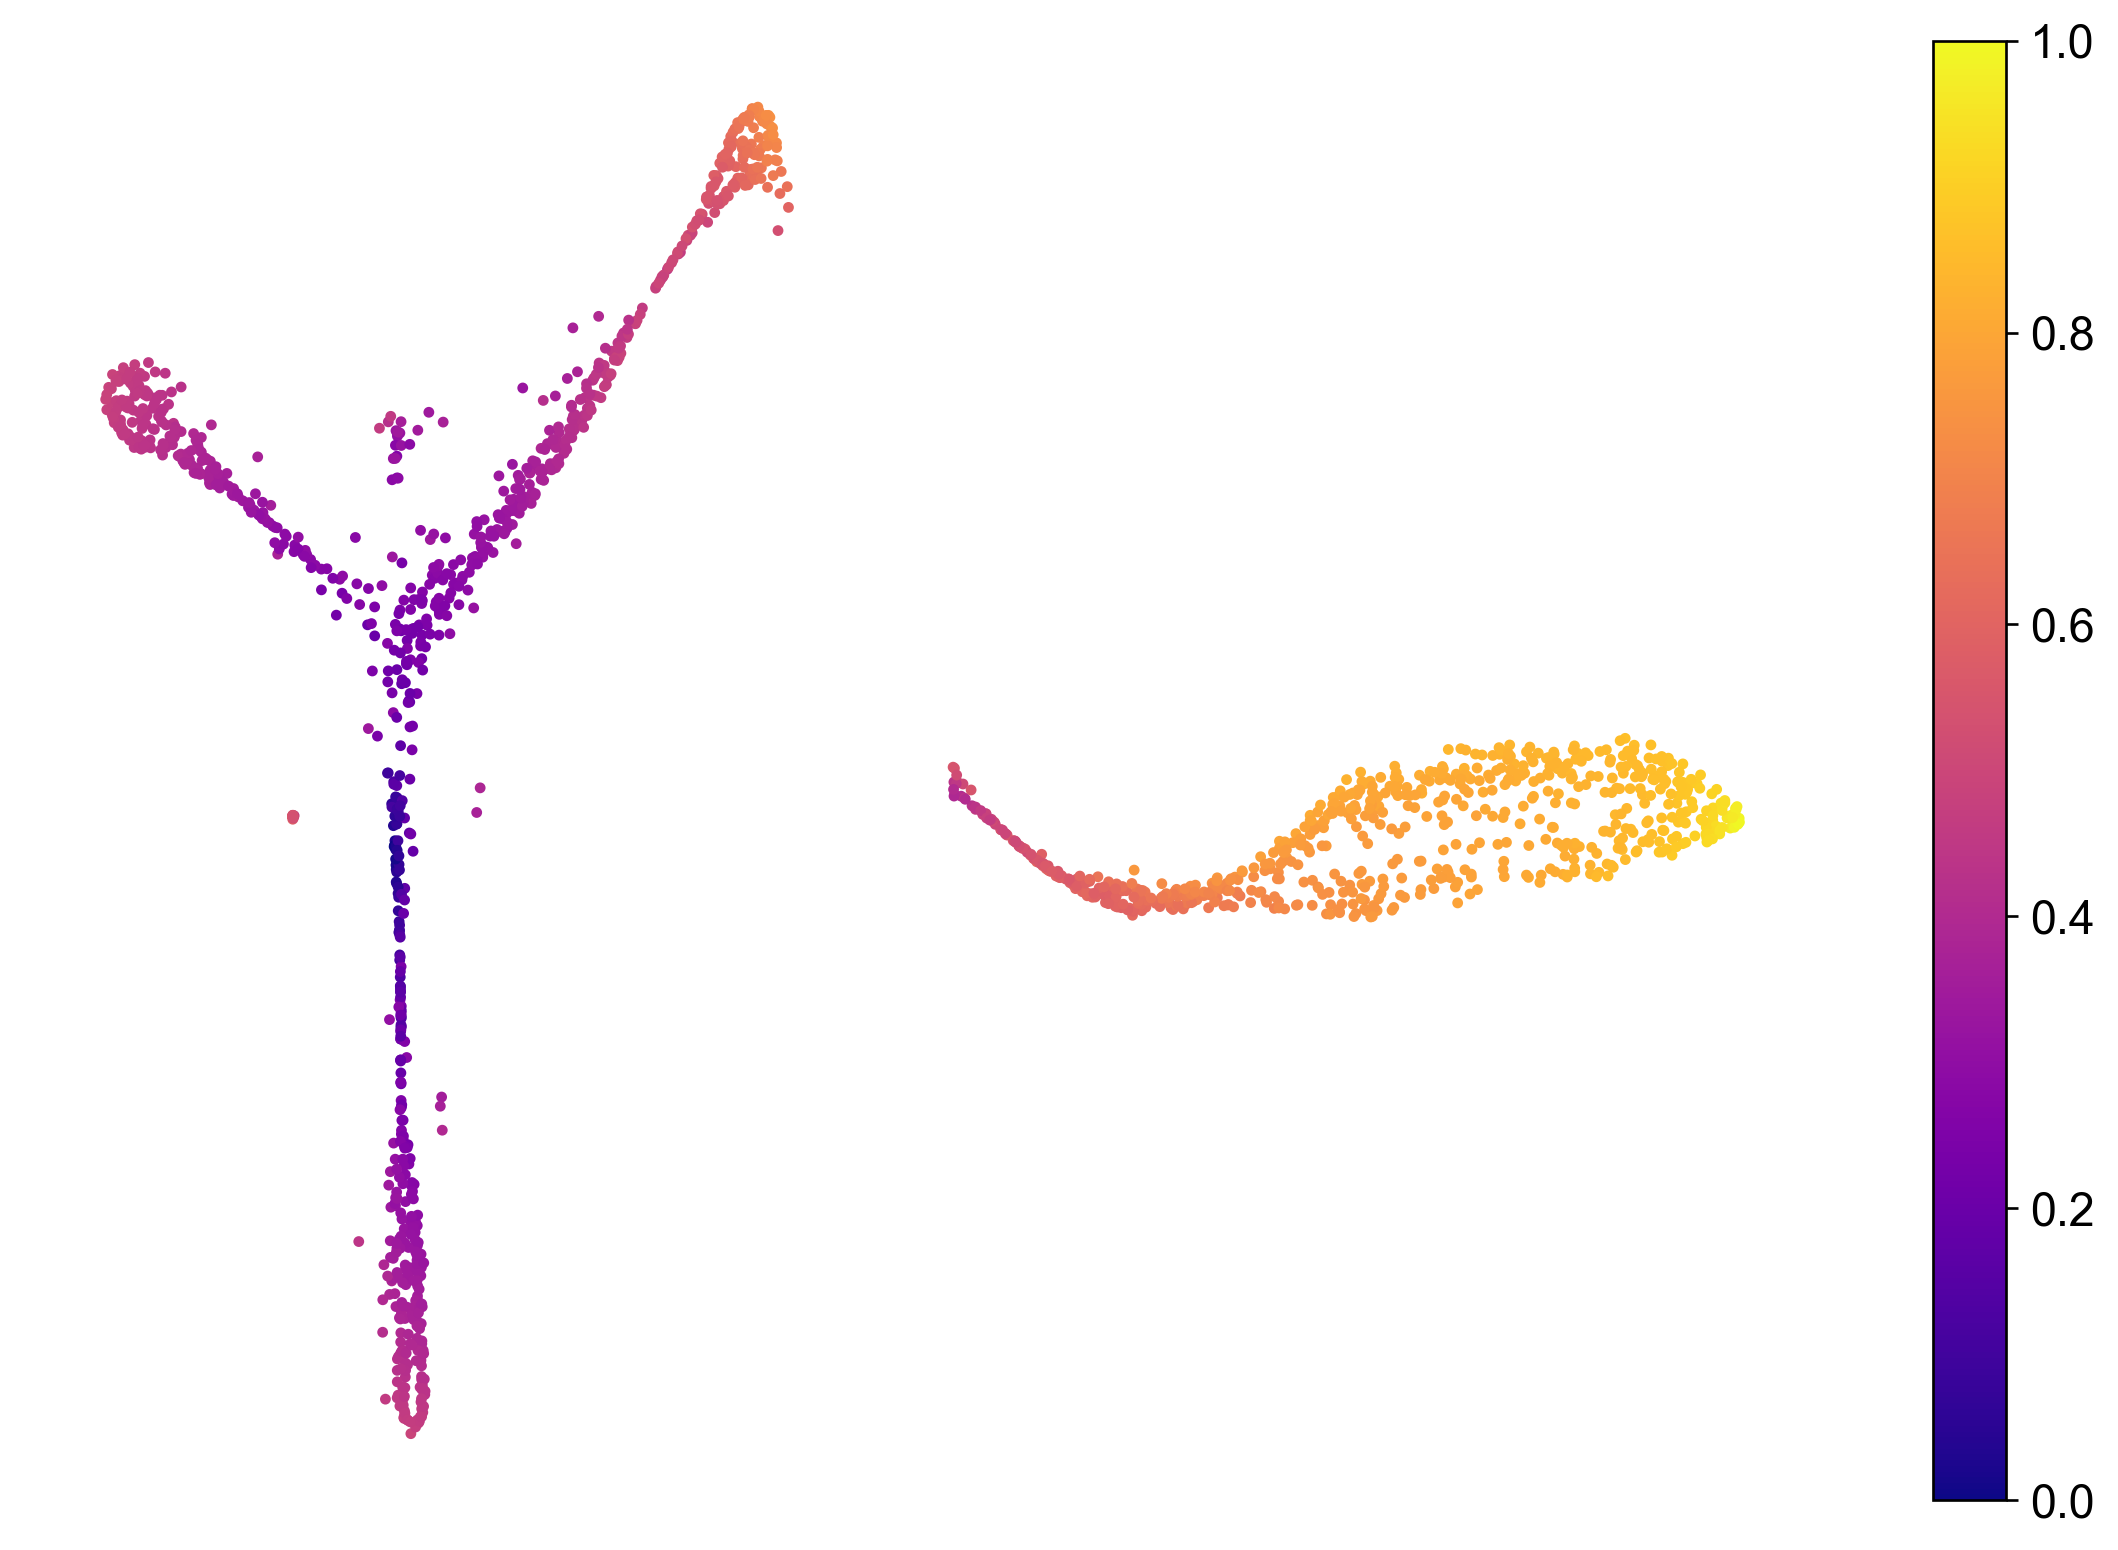

In [ ]:
plot_embeddings(
    X_dm,
    s=5,
    c=presults.pseudotime,
    cmap='plasma',
    show_colorbar=True
)

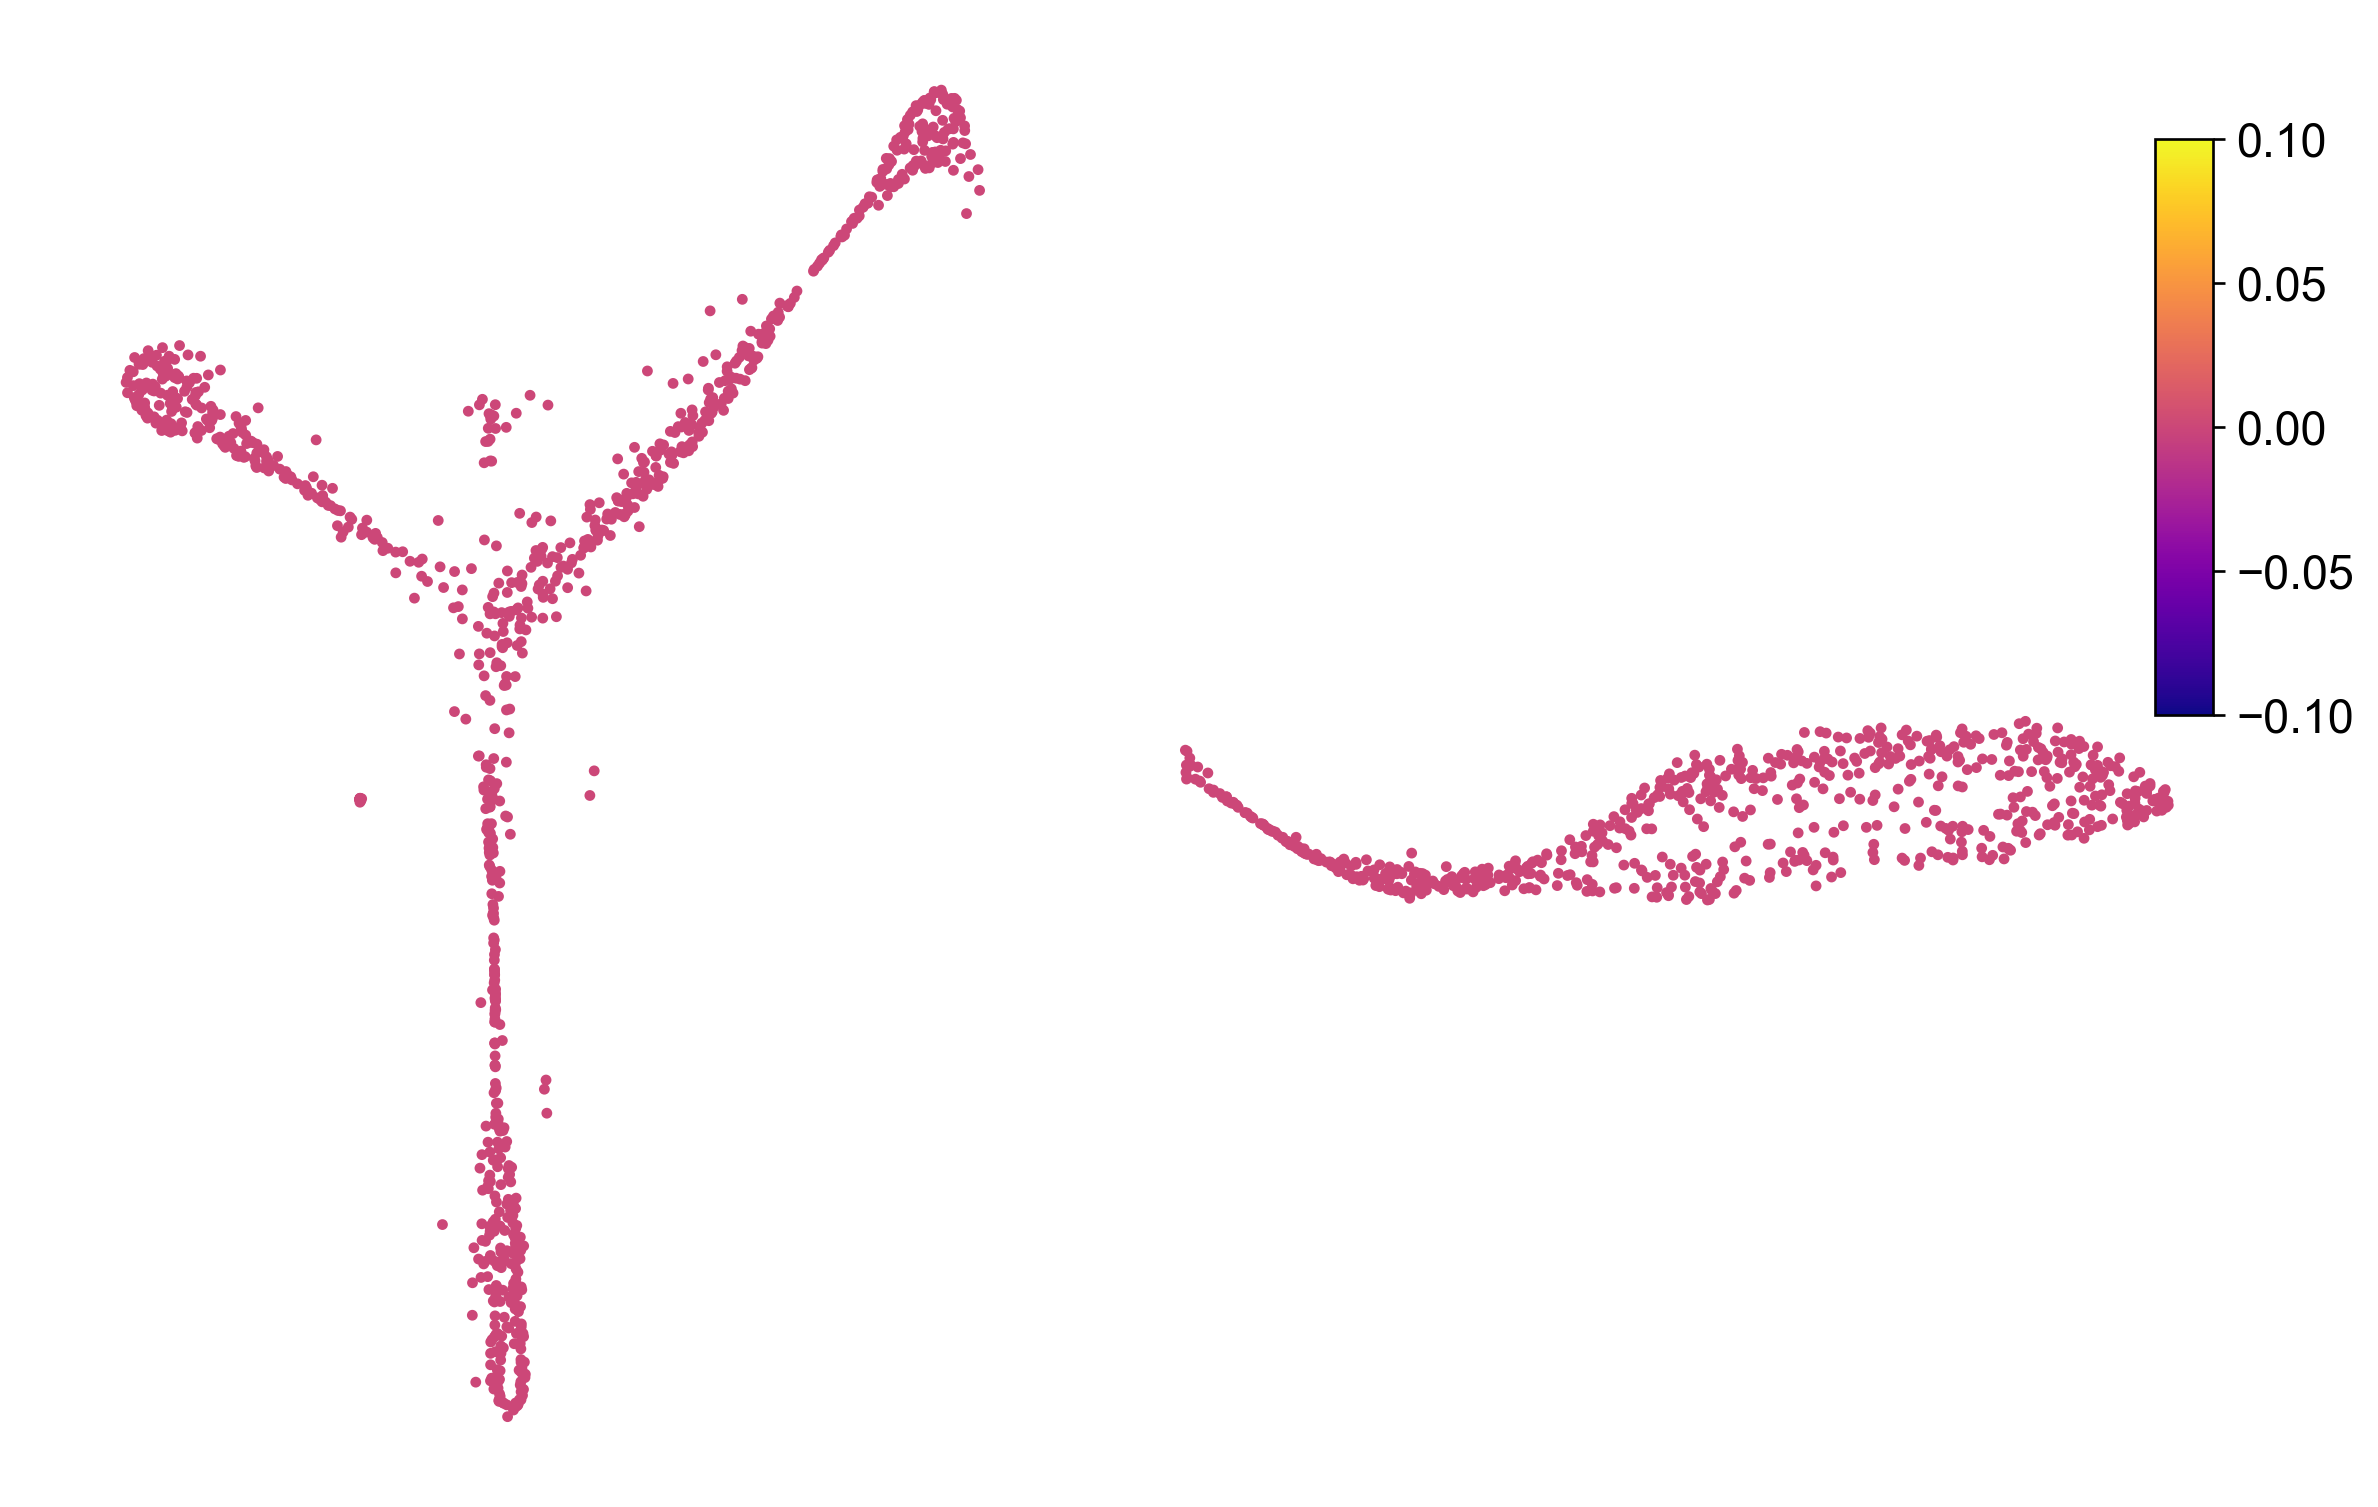

In [ ]:
plot_embeddings(
    X_dm,
    s=5,
    c=presults.entropy,
    cmap='plasma',
    show_colorbar=True,
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3]
)

In [ ]:
import scipy.stats as ss

ss.spearmanr(presults.entropy, adata.uns['timecourse']['pt'])

/home/satwik/dynooenv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


SignificanceResult(statistic=nan, pvalue=nan)

# Palantir metrics

In [ ]:
pal_pseudotime = presults.pseudotime
pal_branch_probs = presults.branch_probs
pal_branch_probs

,Placenta_2.AATAAACTCCATCTGTGT
Placenta_1.AAGCGGAGGGTCAAGCGG,1.0
Placenta_1.CGAGTAAGTCGTCATGAT,1.0
Placenta_1.CGCACCTATTGTGGTACA,1.0
Placenta_1.AGGACTGCCCTCTATGTA,1.0
Placenta_1.GGACATGGACATTGATCA,1.0
...,...
Placenta_2.GACACTTCGTAACTGAAA,1.0
Placenta_2.TCGGGTTCACTTCAAAGT,1.0
Placenta_2.AGTTTAATGGCGGCCTAG,1.0
Placenta_2.TTGGACCGCACCGGCTGC,1.0


In [ ]:
pal_branch_probs.reset_index(inplace=True)
pal_branch_probs.rename(columns={'index': 'cell_id'}, inplace=True)
pal_branch_probs

,cell_id,Placenta_2.AATAAACTCCATCTGTGT
0,Placenta_1.AAGCGGAGGGTCAAGCGG,1.0
1,Placenta_1.CGAGTAAGTCGTCATGAT,1.0
2,Placenta_1.CGCACCTATTGTGGTACA,1.0
3,Placenta_1.AGGACTGCCCTCTATGTA,1.0
4,Placenta_1.GGACATGGACATTGATCA,1.0
...,...,...
1735,Placenta_2.GACACTTCGTAACTGAAA,1.0
1736,Placenta_2.TCGGGTTCACTTCAAAGT,1.0
1737,Placenta_2.AGTTTAATGGCGGCCTAG,1.0
1738,Placenta_2.TTGGACCGCACCGGCTGC,1.0


In [ ]:
%%R -i pal_pseudotime -i pal_branch_probs
pal_dataset <- readRDS("placenta-trophoblast-differentiation-invasive_mca.rds")
pal_traj <- add_end_state_probabilities(
  pal_dataset,
  end_state_probabilities = pal_branch_probs,
  pseudotime = pal_pseudotime,
)

In [ ]:
%%R
pal_metrics <- calculate_metrics(
  dataset = pal_dataset,
  model = pal_traj,
  metrics = c('rf_mse', 'rf_nmse', 'rf_rsq', 'lm_nmse', 'lm_mse', 'lm_rsq', 'edge_flip', 'him', 'isomorphic', 'featureimp_cor', 'featureimp_wcor', 'featureimp_ks', 'featureimp_wilcox', 'F1_branches', 'F1_milestones', 'harm_mean', 'geom_mean', 'arith_mean'),
  expression_source = pal_dataset$expression
)

In [96]:
%%R
cat("HIM =", pal_metrics$him, "\n")
cat("F1_branches =", pal_metrics$F1_branches, "\n")
# cat("correlation =", pal_metrics$correlation, "\n")
cat("featureimp_wcor =", pal_metrics$featureimp_wcor, "\n")
pal_selected_metrics <- c(
  him = as.numeric(pal_metrics$him),
  F1_branches = pal_metrics$F1_branches,
  # correlation = pal_metrics$correlation,
  featureimp_wcor = pal_metrics$featureimp_wcor
)
pal_overall_score <- exp(mean(log(pal_selected_metrics)))
cat("overall_score =", pal_overall_score, "\n")

HIM = 0.4689347 
F1_branches = 0.3147359 
featureimp_wcor = 0.9230861 
overall_score = 0.5145572 


In [ ]:
%%R
# plot_dimred(pal_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

NULL


# paga

In [84]:
import scanpy as sc

In [85]:
# data_path = '/content/drive/MyDrive/project_margaret/simulated/multifurcating/dyntoy_multifurcating_gen_5.h5ad'
# ad = sc.read(data_path)
ad = adata.copy()

In [86]:
# from utils.util import preprocess_recipe

# # Preprocessing using Seurat default parameters
# min_expr_level = 3
# min_cells = None
# use_hvg = False
# n_top_genes = 720
# preprocessed_data = preprocess_recipe(
#     ad,
#     min_expr_level=min_expr_level,
#     min_cells=min_cells,
#     use_hvg=use_hvg,
#     n_top_genes=n_top_genes,
#     scale=True
# )

In [87]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, _, n_comps = run_pca(preprocessed_data, use_hvg=False, n_components=50)
preprocessed_data.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 0.9074187278747559
Components computed: 50


In [88]:
sc.pp.neighbors(preprocessed_data, n_neighbors=15)

In [89]:
sc.tl.umap(preprocessed_data, n_components=2, min_dist=0.1)

In [90]:
sc.pp.neighbors(preprocessed_data, n_neighbors=20, use_rep='X_umap', key_added='knn_umap')

In [91]:
sc.tl.leiden(preprocessed_data, random_state=0, resolution=1.0, neighbors_key='knn_umap')

/tmp/ipykernel_959354/2546193246.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(preprocessed_data, random_state=0, resolution=1.0, neighbors_key='knn_umap')


In [92]:
sc.tl.paga(preprocessed_data, neighbors_key='knn_umap')

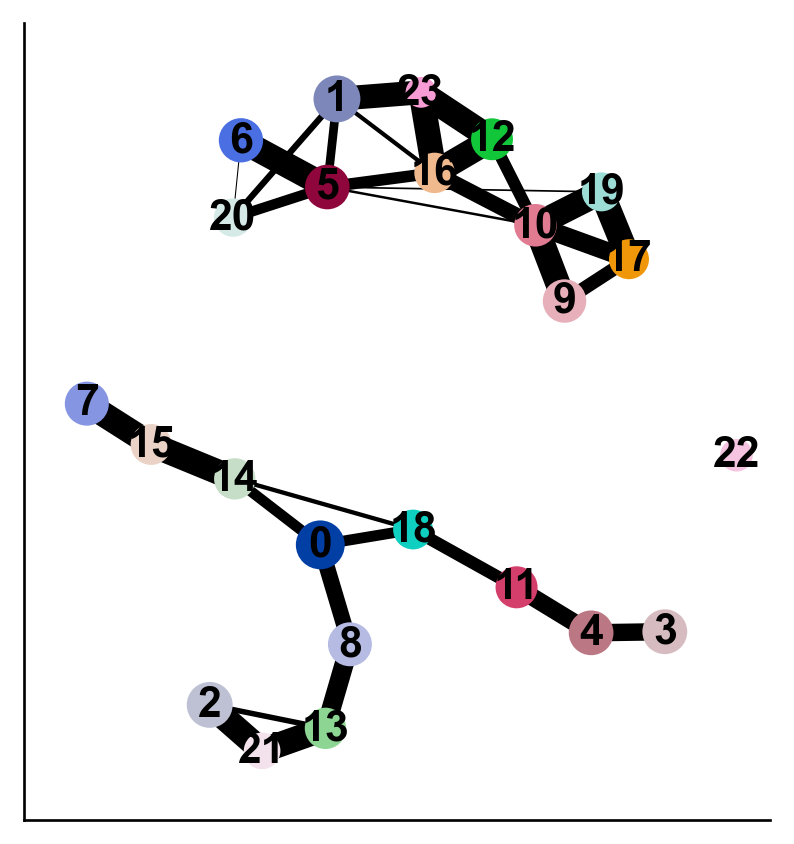

In [93]:
sc.pl.paga(preprocessed_data, save='mono3_d4.png')

In [94]:
import networkx as nx
from models.ti.graph import compute_gt_milestone_network

paga_conns = np.array(preprocessed_data.uns['paga']['connectivities'].todense())
paga_conns_filtered = (paga_conns > 0.05).astype(int)
g = nx.from_numpy_array(paga_conns_filtered)
gt = compute_gt_milestone_network(preprocessed_data, mode='undirected')

Runtime for compute_gt_milestone_network(): 0.001329183578491211


In [95]:
from metrics.ipsen import IpsenMikhailov

im = IpsenMikhailov()
dist = im(g, gt)
print(dist)

0.5133318822451938


# Paga metrics

In [96]:
%%R
paga_dataset <- readRDS("placenta-trophoblast-differentiation-invasive_mca.rds")

In [97]:
cell_ids = preprocessed_data.obs_names.to_list()
paga_milestone_ids = list(g.nodes())
for i in range(len(paga_milestone_ids)):
    paga_milestone_ids[i] = str(paga_milestone_ids[i])
paga_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': list(preprocessed_data.obs["leiden"].astype(str)), 'percentage': [1 for i in range(len(cell_ids))]})
paga_milestone_percentages

,cell_id,milestone_id,percentage
0,Placenta_1.AAGCGGAGGGTCAAGCGG,6,1
1,Placenta_1.CGAGTAAGTCGTCATGAT,5,1
2,Placenta_1.CGCACCTATTGTGGTACA,20,1
3,Placenta_1.AGGACTGCCCTCTATGTA,5,1
4,Placenta_1.GGACATGGACATTGATCA,6,1
...,...,...,...
1735,Placenta_2.GACACTTCGTAACTGAAA,9,1
1736,Placenta_2.TCGGGTTCACTTCAAAGT,0,1
1737,Placenta_2.AGTTTAATGGCGGCCTAG,9,1
1738,Placenta_2.TTGGACCGCACCGGCTGC,14,1


In [98]:
fromlist = []
tolist = []
for t in g.edges:
    fromlist.append(str(t[0]))
    tolist.append(str(t[1]))
paga_edges_df = pd.DataFrame({'from': fromlist, 'to': tolist, 'length': 1, 'directed': False})
paga_edges_df

,from,to,length,directed
0,0,8,1,False
1,0,14,1,False
2,0,18,1,False
3,1,5,1,False
4,1,16,1,False
5,1,20,1,False
6,1,23,1,False
7,2,13,1,False
8,2,21,1,False
9,3,4,1,False


In [99]:
disconnected = set(paga_milestone_ids)
for i in paga_edges_df['from']:
    disconnected.discard(i)
for i in paga_edges_df['to']:  
    disconnected.discard(i)
disconnected = list(disconnected)
disconnected

['22']

In [100]:
new_rows = [{'from': i, 'to': i, 'length': 0, 'directed': True} for i in disconnected]
paga_edges_df = pd.concat([paga_edges_df, pd.DataFrame(new_rows)], ignore_index=True)
paga_edges_df

,from,to,length,directed
0,0,8,1,False
1,0,14,1,False
2,0,18,1,False
3,1,5,1,False
4,1,16,1,False
5,1,20,1,False
6,1,23,1,False
7,2,13,1,False
8,2,21,1,False
9,3,4,1,False


In [101]:
paga_progressions = pd.DataFrame({
    'cell_id': cell_ids,
    'from': [1 for i in range(len(cell_ids))],
    'to': [1 for i in range(len(cell_ids))],
    'percentage': [1 for i in range(len(cell_ids))]
})
paga_progressions

,cell_id,from,to,percentage
0,Placenta_1.AAGCGGAGGGTCAAGCGG,1,1,1
1,Placenta_1.CGAGTAAGTCGTCATGAT,1,1,1
2,Placenta_1.CGCACCTATTGTGGTACA,1,1,1
3,Placenta_1.AGGACTGCCCTCTATGTA,1,1,1
4,Placenta_1.GGACATGGACATTGATCA,1,1,1
...,...,...,...,...
1735,Placenta_2.GACACTTCGTAACTGAAA,1,1,1
1736,Placenta_2.TCGGGTTCACTTCAAAGT,1,1,1
1737,Placenta_2.AGTTTAATGGCGGCCTAG,1,1,1
1738,Placenta_2.TTGGACCGCACCGGCTGC,1,1,1


In [102]:
paga_cell_to_milestone = dict(zip(paga_milestone_percentages['cell_id'], paga_milestone_percentages['milestone_id']))
paga_progressions['milestone'] = paga_progressions['cell_id'].map(paga_cell_to_milestone)
paga_progressions

,cell_id,from,to,percentage,milestone
0,Placenta_1.AAGCGGAGGGTCAAGCGG,1,1,1,6
1,Placenta_1.CGAGTAAGTCGTCATGAT,1,1,1,5
2,Placenta_1.CGCACCTATTGTGGTACA,1,1,1,20
3,Placenta_1.AGGACTGCCCTCTATGTA,1,1,1,5
4,Placenta_1.GGACATGGACATTGATCA,1,1,1,6
...,...,...,...,...,...
1735,Placenta_2.GACACTTCGTAACTGAAA,1,1,1,9
1736,Placenta_2.TCGGGTTCACTTCAAAGT,1,1,1,0
1737,Placenta_2.AGTTTAATGGCGGCCTAG,1,1,1,9
1738,Placenta_2.TTGGACCGCACCGGCTGC,1,1,1,14


In [103]:
import random

# Iterate through each row in the progressions DataFrame
for idx, row in paga_progressions.iterrows():
    milestone = row['milestone']
    
    # Filter rows in the milestone_network (paga_edges_df) where the milestone is in 'from' or 'to'
    matching_rows = paga_edges_df[(paga_edges_df['from'] == milestone) | (paga_edges_df['to'] == milestone)]
    
    # Pick one row at random from the matching rows
    selected_row = matching_rows.sample(n=1).iloc[0]
    
    # Update the 'from' and 'to' columns in paga_progressions
    paga_progressions.at[idx, 'from'] = selected_row['from']
    paga_progressions.at[idx, 'to'] = selected_row['to']
    
    # Update the 'percentage' column based on whether the milestone was in 'from' or 'to'
    if selected_row['from'] == milestone:
        paga_progressions.at[idx, 'percentage'] = 0
    elif selected_row['to'] == milestone:
        paga_progressions.at[idx, 'percentage'] = 1

paga_progressions

,cell_id,from,to,percentage,milestone
0,Placenta_1.AAGCGGAGGGTCAAGCGG,5,6,1,6
1,Placenta_1.CGAGTAAGTCGTCATGAT,5,6,0,5
2,Placenta_1.CGCACCTATTGTGGTACA,1,20,1,20
3,Placenta_1.AGGACTGCCCTCTATGTA,5,10,0,5
4,Placenta_1.GGACATGGACATTGATCA,5,6,1,6
...,...,...,...,...,...
1735,Placenta_2.GACACTTCGTAACTGAAA,9,10,0,9
1736,Placenta_2.TCGGGTTCACTTCAAAGT,0,18,0,0
1737,Placenta_2.AGTTTAATGGCGGCCTAG,9,12,0,9
1738,Placenta_2.TTGGACCGCACCGGCTGC,0,14,1,14


In [104]:
paga_progressions.percentage.value_counts()

percentage
0    1027
1     713
Name: count, dtype: int64

In [105]:
del paga_progressions['milestone']

In [106]:
%%R -i cell_ids -i paga_milestone_ids -i paga_milestone_percentages -i paga_edges_df -i paga_progressions
paga_traj <- add_trajectory(
  paga_dataset,
  cell_ids = cell_ids,
  milestone_ids = as.vector(paga_milestone_ids),
  milestone_percentages = paga_milestone_percentages,
  milestone_network = paga_edges_df,
  allow_self_loops = TRUE,
  progressions = paga_progressions
)

In addition: Warning message:
In add_trajectory(paga_dataset, cell_ids = cell_ids, milestone_ids = as.vector(paga_milestone_ids),  :
  Both milestone_percentages and progressions are given, will only use progressions


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


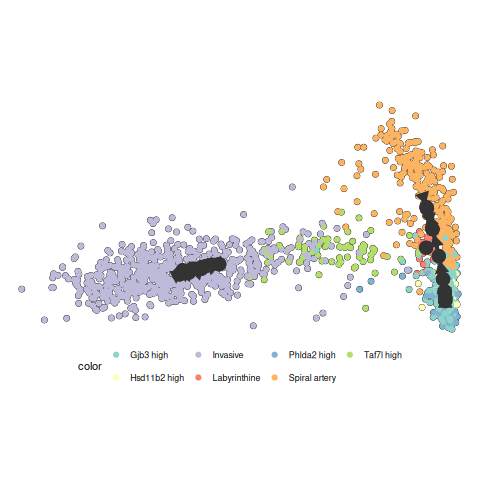

In [107]:
%%R
plot_dimred(paga_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [122]:
%%R
paga_traj$milestone_network <- paga_traj$milestone_network[paga_traj$milestone_network$length != 0, ]
# paga_traj$milestone_network

In [123]:
%%R
paga_metrics <- calculate_metrics(
  dataset = paga_dataset,
  model = paga_traj,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = paga_dataset$expression
)

In [124]:
%%R
cat("HIM =", paga_metrics$him, "\n")
cat("F1_branches =", paga_metrics$F1_branches, "\n")
cat("correlation =", paga_metrics$correlation, "\n")
cat("featureimp_wcor =", paga_metrics$featureimp_wcor, "\n")
paga_selected_metrics <- c(
  him = as.numeric(paga_metrics$him),
  F1_branches = paga_metrics$F1_branches,
  correlation = paga_metrics$correlation,
  featureimp_wcor = paga_metrics$featureimp_wcor
)
paga_overall_score <- exp(mean(log(paga_selected_metrics)))
cat("overall_score =", paga_overall_score, "\n")

HIM = 0.3482552 
F1_branches = 0.1556826 
correlation = 0.8476976 
featureimp_wcor = 0.5798072 
overall_score = 0.4040318 


In [109]:
%%R
library(dyneval)
dataset$counts <- Matrix::Matrix(dataset$counts, sparse = TRUE)
dataset$expression <- Matrix::Matrix(dataset$expression, sparse = TRUE)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


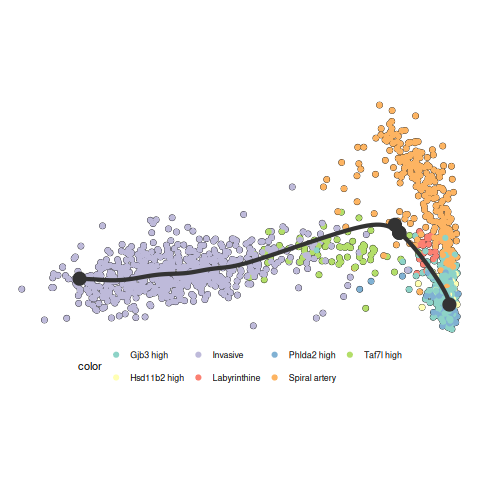

In [112]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))
plot_dimred(dpt_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

HIM = 0.5114656 
F1_branches = 0.5013435 
correlation = 0.7383741 
featureimp_wcor = 0.9596142 
overall_score = 0.6528768 


Coloring by milestone
Using milestone_percentages from trajectory


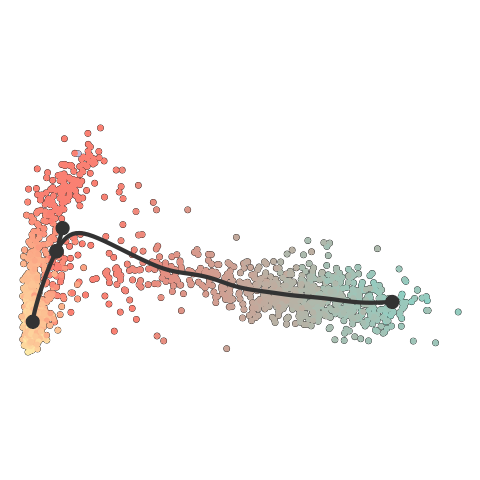

In [ ]:
%%R
dpt_model <- add_cell_waypoints(dpt_model)
dpt_metrics <- calculate_metrics(
  dataset = dataset,
  model = dpt_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = dataset$expression
)
cat("HIM =", dpt_metrics$him, "\n")
cat("F1_branches =", dpt_metrics$F1_branches, "\n")
cat("correlation =", dpt_metrics$correlation, "\n")
cat("featureimp_wcor =", dpt_metrics$featureimp_wcor, "\n")
dpt_selected_metrics <- c(
  him = as.numeric(dpt_metrics$him),
  F1_branches = dpt_metrics$F1_branches,
  correlation = dpt_metrics$correlation,
  featureimp_wcor = dpt_metrics$featureimp_wcor
)
dpt_overall_score <- exp(mean(log(dpt_selected_metrics)))
cat("overall_score =", dpt_overall_score, "\n")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'tislingshot' from a github remote, the SHA1 (65248eca) has not changed since last install.
  Use `force = TRUE` to force installation


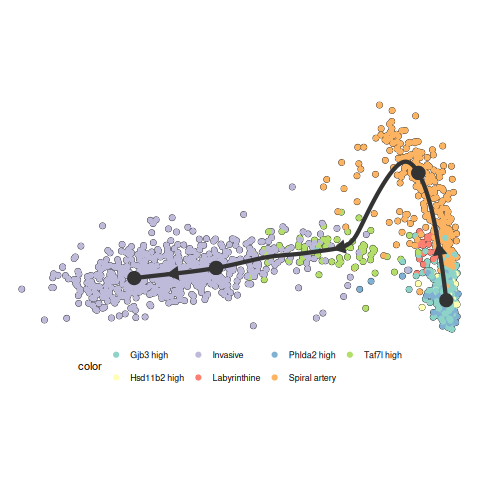

In [114]:
%%R
slingshot_model <- infer_trajectory(dataset, ti_slingshot(), give_priors = c("start_id"))
plot_dimred(slingshot_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

HIM = 0.4689347 
F1_branches = 0.5546902 
correlation = 0.8110031 
featureimp_wcor = 0.95903 
overall_score = 0.6706631 


You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'tislingshot' from a github remote, the SHA1 (65248eca) has not changed since last install.
  Use `force = TRUE` to force installation
Coloring by milestone
Using milestone_percentages from trajectory


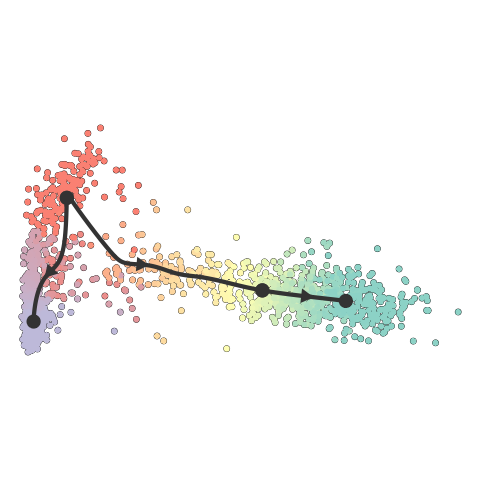

In [ ]:
%%R
slingshot_model <- add_cell_waypoints(slingshot_model)
slingshot_metrics <- calculate_metrics(
  dataset = dataset,
  model = slingshot_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = dataset$expression
)
cat("HIM =", slingshot_metrics$him, "\n")
cat("F1_branches =", slingshot_metrics$F1_branches, "\n")
cat("correlation =", slingshot_metrics$correlation, "\n")
cat("featureimp_wcor =", slingshot_metrics$featureimp_wcor, "\n")
slingshot_selected_metrics <- c(
  him = as.numeric(slingshot_metrics$him),
  F1_branches = slingshot_metrics$F1_branches,
  correlation = slingshot_metrics$correlation,
  featureimp_wcor = slingshot_metrics$featureimp_wcor
)
slingshot_overall_score <- exp(mean(log(slingshot_selected_metrics)))
cat("overall_score =", slingshot_overall_score, "\n")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


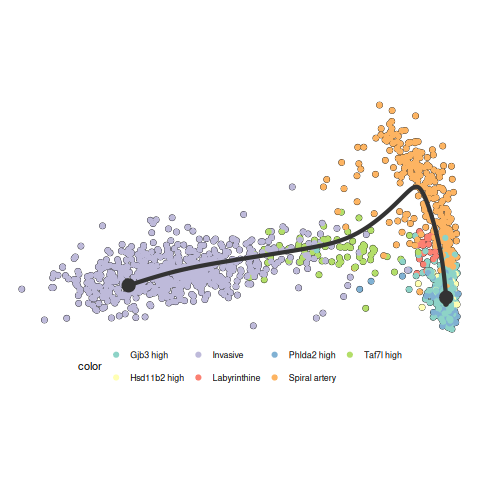

In [115]:
%%R
scorpius_model <- infer_trajectory(dataset, ti_scorpius(), give_priors = c("start_id"))
plot_dimred(scorpius_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

HIM = 0.4689347 
F1_branches = 0.3147359 
correlation = 0.8414524 
featureimp_wcor = 0.9382532 
overall_score = 0.5842545 


Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation
Coloring by milestone
Using milestone_percentages from trajectory


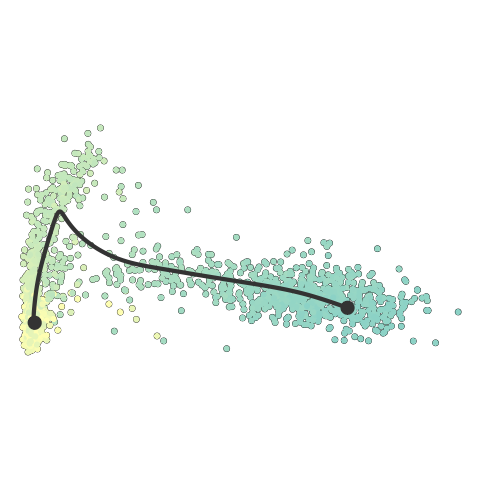

In [ ]:
%%R
scorpius_model <- add_cell_waypoints(scorpius_model)
scorpius_metrics <- calculate_metrics(
  dataset = dataset,
  model = scorpius_model,
  metrics = c("him", "F1_branches", "correlation", "featureimp_wcor"),
  expression_source = dataset$expression
)
cat("HIM =", scorpius_metrics$him, "\n")
cat("F1_branches =", scorpius_metrics$F1_branches, "\n")
cat("correlation =", scorpius_metrics$correlation, "\n")
cat("featureimp_wcor =", scorpius_metrics$featureimp_wcor, "\n")
scorpius_selected_metrics <- c(
  him = as.numeric(scorpius_metrics$him),
  F1_branches = scorpius_metrics$F1_branches,
  correlation = scorpius_metrics$correlation,
  featureimp_wcor = scorpius_metrics$featureimp_wcor
)
scorpius_overall_score <- exp(mean(log(scorpius_selected_metrics)))
cat("overall_score =", scorpius_overall_score, "\n")

In [ ]:
%%R -o via_metrics -o marg_metrics -o pal_metrics -o paga_metrics -o dpt_metrics -o slingshot_metrics -o scorpius_metrics
print('outputs')

[1] "outputs"


In [ ]:
# List of dataframes to combine
dataframes = [
    via_metrics, marg_metrics, pal_metrics, paga_metrics, dpt_metrics, slingshot_metrics, scorpius_metrics
]

# Find all unique columns across all dataframes
all_columns = set().union(*(df.columns for df in dataframes))

# Ensure all dataframes have the same columns, filling missing ones with 0
aligned_dataframes = [
    df.reindex(columns=all_columns, fill_value=0) if df is pal_metrics else df
    for df in dataframes
]

# Combine all dataframes
combined_metrics = pd.concat(aligned_dataframes, ignore_index=True)
combined_metrics.index = ['Via', 'Margaret', 'Palantir', 'PAGA', 'DPT', 'Slingshot', 'Scorpius']

In [26]:
combined_metrics.to_csv("combined_metrics_placenta.csv", index=True)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_metrics = pd.read_csv("combined_metrics_placenta.csv", index_col=0)
combined_metrics

,time_waypointedgeodesic,correlation,time_correlation,him,time_him,time_featureimp,featureimp_cor,featureimp_wcor,time_mapping_branches,recovery_branches,...,F1_milestones,isomorphic,rf_rsq,time_edge_flip,lm_nmse,featureimp_wilcox,time_featureimp_enrichment,time_pp,relevance_milestones,rf_nmse
Via,1.103885,0.730064,0.054202,0.429020,0.129347,51.747572,0.820750,0.847778,0.531498,0.608197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Margaret,0.793289,0.764917,0.056817,0.673244,0.075886,41.041521,0.905435,0.936252,0.482112,0.402328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Palantir,0.000000,0.000000,0.000000,0.468935,0.071693,25.320309,0.926904,0.923086,0.462212,0.250000,...,0.417925,0.0,0.02683,0.095901,0.373862,1.0,9.694889,16.224412,0.728311,0.281497
PAGA,1.332651,0.847698,0.060716,0.348255,0.078280,62.916158,0.679516,0.579807,0.476904,0.317714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DPT,2.473059,0.738374,0.158892,0.511466,0.050975,29.993697,0.963074,0.959614,0.535334,0.467821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Slingshot,2.047719,0.811003,0.138582,0.468935,0.056200,32.047393,0.962952,0.959030,0.517713,0.444760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scorpius,3.731575,0.841452,0.163998,0.468935,0.107943,25.715493,0.936123,0.938253,0.466317,0.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from scipy.stats import gmean

selected_metrics = combined_metrics[['him', 'F1_branches', 'correlation', 'featureimp_wcor']].copy()
selected_metrics.loc['Palantir', 'correlation'] = selected_metrics[selected_metrics.index != 'Palantir']['correlation'].mean()
selected_metrics['Overall Score'] = selected_metrics.apply(gmean, axis=1)
selected_metrics.rename(columns={'him': 'HIM', 'correlation': 'Correlation', 'featureimp_wcor': 'Featureimp_wcor'}, inplace=True)
selected_metrics

,HIM,F1_branches,Correlation,Featureimp_wcor,Overall Score
Via,0.429020,0.279151,0.730064,0.847778,0.521783
Margaret,0.673244,0.355517,0.764917,0.936252,0.643443
Palantir,0.468935,0.314736,0.788918,0.923086,0.572576
PAGA,0.348255,0.155683,0.847698,0.579807,0.404032
DPT,0.511466,0.501343,0.738374,0.959614,0.652877
Slingshot,0.468935,0.554690,0.811003,0.959030,0.670663
Scorpius,0.468935,0.314736,0.841452,0.938253,0.584255


In [13]:
# Identify columns that start with 'time_'
time_columns = [col for col in combined_metrics.columns if col.startswith('time_')]

# Identify other columns
other_columns = [col for col in combined_metrics.columns if not col.startswith('time_')]

# Reorder the columns
reordered_columns = other_columns + time_columns

# Reorder the DataFrame
combined_metrics = combined_metrics[reordered_columns]
combined_metrics

,correlation,him,featureimp_cor,featureimp_wcor,recovery_branches,relevance_branches,F1_branches,lm_mse,rf_mse,lm_rsq,...,time_waypointedgeodesic,time_correlation,time_him,time_featureimp,time_mapping_branches,time_mapping_milestones,time_isomorphic,time_edge_flip,time_featureimp_enrichment,time_pp
Via,0.730064,0.429020,0.820750,0.847778,0.608197,0.181147,0.279151,NaN,NaN,NaN,...,1.103885,0.054202,0.129347,51.747572,0.531498,NaN,NaN,NaN,NaN,NaN
Margaret,0.764917,0.673244,0.905435,0.936252,0.402328,0.318463,0.355517,NaN,NaN,NaN,...,0.793289,0.056817,0.075886,41.041521,0.482112,NaN,NaN,NaN,NaN,NaN
Palantir,0.000000,0.468935,0.926904,0.923086,0.250000,0.424713,0.314736,0.069956,0.080275,0.207215,...,0.000000,0.000000,0.071693,25.320309,0.462212,0.456074,0.00061,0.095901,9.694889,16.224412
PAGA,0.847698,0.348255,0.679516,0.579807,0.317714,0.103102,0.155683,NaN,NaN,NaN,...,1.332651,0.060716,0.078280,62.916158,0.476904,NaN,NaN,NaN,NaN,NaN
DPT,0.738374,0.511466,0.963074,0.959614,0.467821,0.540041,0.501343,NaN,NaN,NaN,...,2.473059,0.158892,0.050975,29.993697,0.535334,NaN,NaN,NaN,NaN,NaN
Slingshot,0.811003,0.468935,0.962952,0.959030,0.444760,0.736803,0.554690,NaN,NaN,NaN,...,2.047719,0.138582,0.056200,32.047393,0.517713,NaN,NaN,NaN,NaN,NaN
Scorpius,0.841452,0.468935,0.936123,0.938253,0.250000,0.424713,0.314736,NaN,NaN,NaN,...,3.731575,0.163998,0.107943,25.715493,0.466317,NaN,NaN,NaN,NaN,NaN


In [14]:
# Normalize only time metrics
normalized_metrics = combined_metrics.copy()
normalized_metrics[time_columns] = combined_metrics[time_columns].div(combined_metrics[time_columns].max(axis=0), axis=1)
normalized_metrics

,correlation,him,featureimp_cor,featureimp_wcor,recovery_branches,relevance_branches,F1_branches,lm_mse,rf_mse,lm_rsq,...,time_waypointedgeodesic,time_correlation,time_him,time_featureimp,time_mapping_branches,time_mapping_milestones,time_isomorphic,time_edge_flip,time_featureimp_enrichment,time_pp
Via,0.730064,0.429020,0.820750,0.847778,0.608197,0.181147,0.279151,NaN,NaN,NaN,...,0.295823,0.330503,1.000000,0.822485,0.992833,NaN,NaN,NaN,NaN,NaN
Margaret,0.764917,0.673244,0.905435,0.936252,0.402328,0.318463,0.355517,NaN,NaN,NaN,...,0.212588,0.346448,0.586683,0.652321,0.900581,NaN,NaN,NaN,NaN,NaN
Palantir,0.000000,0.468935,0.926904,0.923086,0.250000,0.424713,0.314736,0.069956,0.080275,0.207215,...,0.000000,0.000000,0.554266,0.402445,0.863407,1.0,1.0,1.0,1.0,1.0
PAGA,0.847698,0.348255,0.679516,0.579807,0.317714,0.103102,0.155683,NaN,NaN,NaN,...,0.357128,0.370225,0.605191,1.000000,0.890852,NaN,NaN,NaN,NaN,NaN
DPT,0.738374,0.511466,0.963074,0.959614,0.467821,0.540041,0.501343,NaN,NaN,NaN,...,0.662739,0.968866,0.394094,0.476725,1.000000,NaN,NaN,NaN,NaN,NaN
Slingshot,0.811003,0.468935,0.962952,0.959030,0.444760,0.736803,0.554690,NaN,NaN,NaN,...,0.548755,0.845025,0.434486,0.509367,0.967084,NaN,NaN,NaN,NaN,NaN
Scorpius,0.841452,0.468935,0.936123,0.938253,0.250000,0.424713,0.314736,NaN,NaN,NaN,...,1.000000,1.000000,0.834524,0.408726,0.871077,NaN,NaN,NaN,NaN,NaN


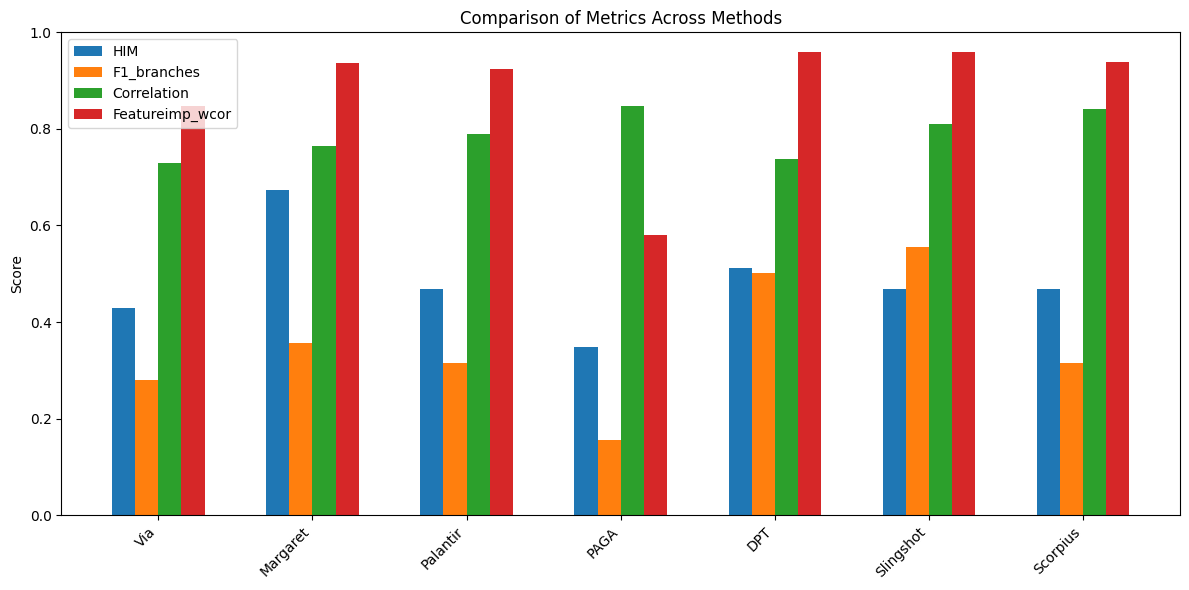

In [15]:
import pandas as pd

import matplotlib.pyplot as plt

# Assuming `metrics` is already defined as a DataFrame
columns_to_plot = ['HIM', 'F1_branches', 'Correlation', 'Featureimp_wcor']
methods = selected_metrics.index

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
bar_width = 0.15
x = range(len(methods))

for i, column in enumerate(columns_to_plot):
    ax.bar(
        [pos + i * bar_width for pos in x],
        selected_metrics[column],
        bar_width,
        label=column
    )

# Set x-axis labels and ticks
ax.set_xticks([pos + (len(columns_to_plot) - 1) * bar_width / 2 for pos in x])
ax.set_xticklabels(methods, rotation=45, ha='right')

# Set y-axis limits
ax.set_ylim(0, 1)

# Add labels and legend
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Methods')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

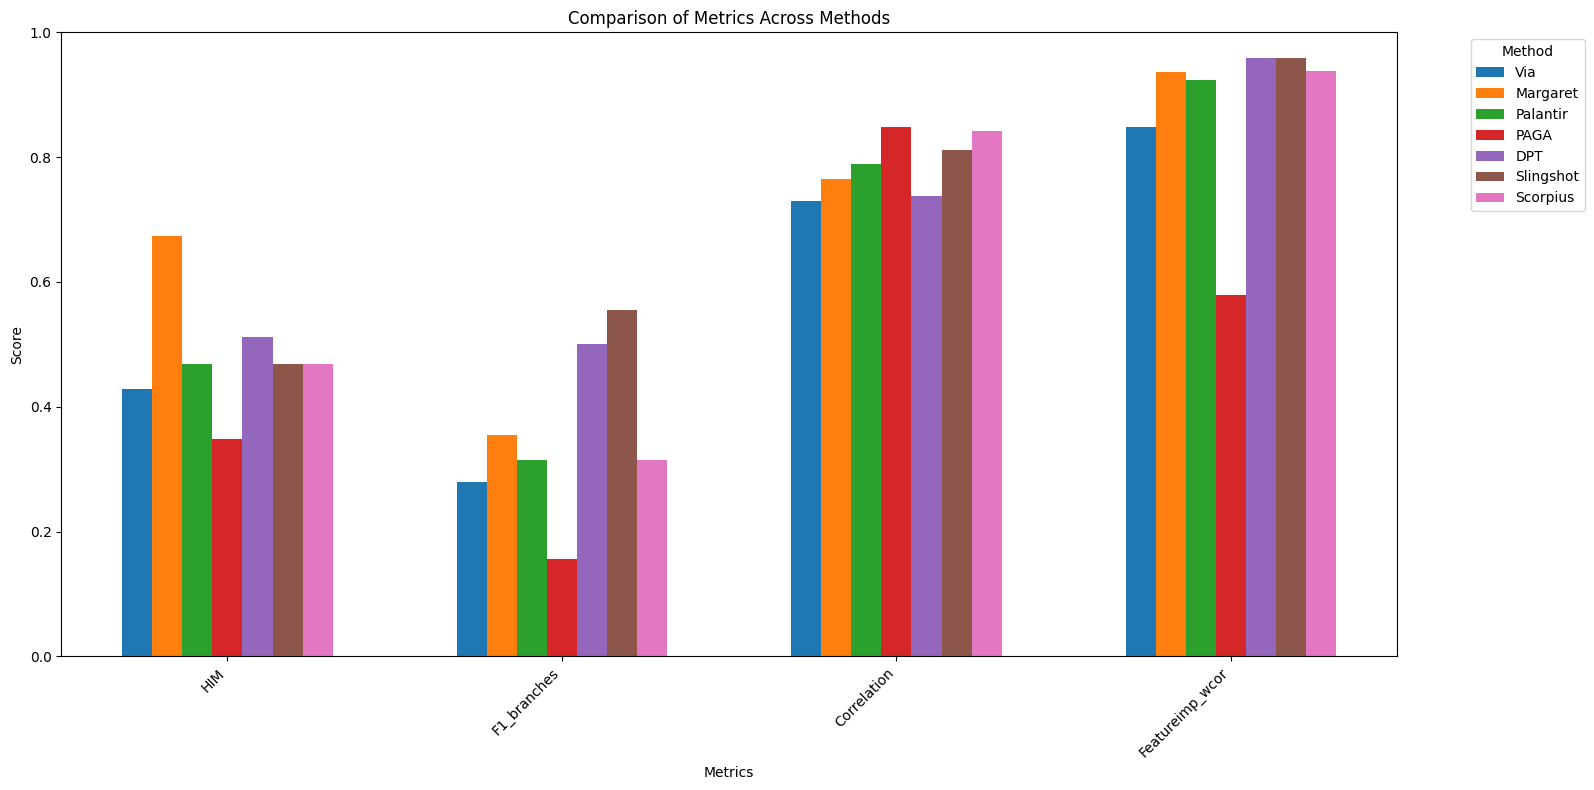

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Selected metrics (without Overall Score)
columns_to_plot = ['HIM', 'F1_branches', 'Correlation', 'Featureimp_wcor']
metrics_df = selected_metrics[columns_to_plot]

# Methods (DataFrame index)
methods = metrics_df.index.tolist()
n_metrics = len(columns_to_plot)
n_methods = len(methods)

# Create x positions for metric groups
x = np.arange(n_metrics)

# Adjust the bar width and figure size; here we use a slightly smaller width and larger figure
bar_width = 0.09

fig, ax = plt.subplots(figsize=(16, 8))

for i, method in enumerate(methods):
    ax.bar(x + i * bar_width,
           metrics_df.loc[method].values,
           bar_width,
           label=method)

# Center the x-axis ticks within each group
ax.set_xticks(x + (n_methods - 1) * bar_width / 2)
ax.set_xticklabels(columns_to_plot, rotation=45, ha='right')

ax.set_ylim(0, 1)
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Methods')

# Place the legend outside the plot for clarity
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


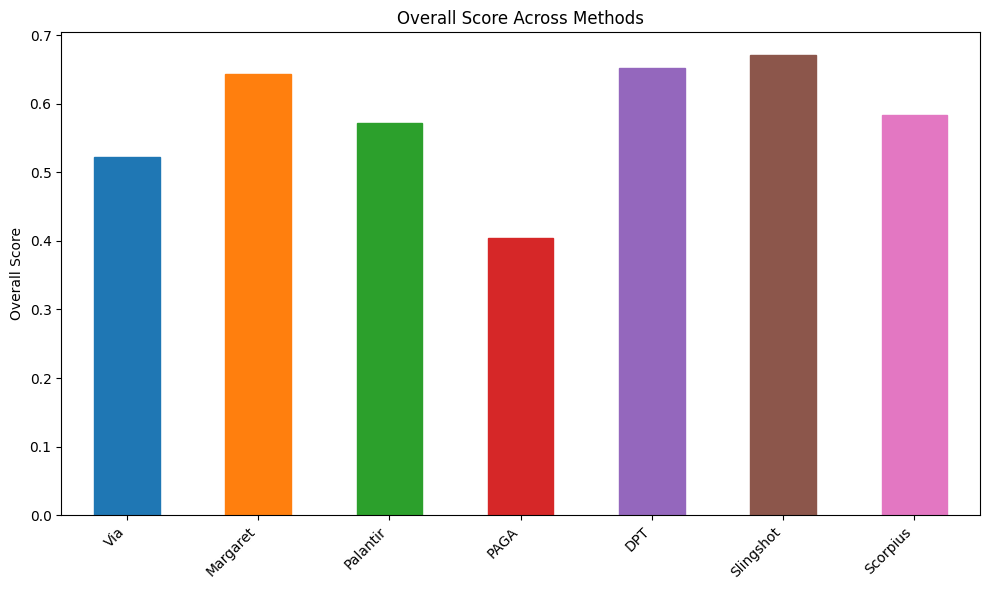

In [17]:
# Plot the Overall Score
plt.figure(figsize=(10, 6))
selected_metrics['Overall Score'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Overall Score')
plt.title('Overall Score Across Methods')
plt.xticks(rotation=45, ha='right')
# Assign the same colors to the bars as in the plot above
colors = plt.cm.tab10(range(len(selected_metrics)))
for bar, color in zip(plt.gca().patches, colors):
    bar.set_color(color)
# Show the plot
plt.tight_layout()
plt.show()

In [18]:
selected_metrics.to_csv("selected_metrics_placenta.csv", index=True)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

selected_metrics = pd.read_csv("selected_metrics_placenta.csv", index_col=0)
selected_metrics

,HIM,F1_branches,Correlation,Featureimp_wcor,Overall Score
Via,0.429020,0.279151,0.730064,0.847778,0.521783
Margaret,0.673244,0.355517,0.764917,0.936252,0.643443
Palantir,0.468935,0.314736,0.788918,0.923086,0.572576
PAGA,0.348255,0.155683,0.847698,0.579807,0.404032
DPT,0.511466,0.501343,0.738374,0.959614,0.652877
Slingshot,0.468935,0.554690,0.811003,0.959030,0.670663
Scorpius,0.468935,0.314736,0.841452,0.938253,0.584255
